In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import plotly.graph_objects as go
import plotly.express as px
import seaborn as sns
import colorsys
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [12]:
deliveries = pd.read_csv("deliveries.csv")
deliveries  = deliveries.drop(columns=['is_wicket', 'fielder'])
deliveries = deliveries[deliveries['inning'] <= 2]


dismissals = deliveries[['player_dismissed', 'dismissal_kind', 'bowler']].dropna()
dismissals.to_csv('dismissals.csv', index=False)

df = pd.read_csv('matches.csv')

df.drop(['umpire1', 'umpire2'], axis=1, inplace=True)
df.replace({'Delhi Daredevils': 'Delhi Capitals'}, inplace=True)

team_short_form = {
    'Chennai Super Kings': 'CSK',
    'Delhi Capitals': 'DC',
    'Deccan Chargers': 'DEC',
    'Kings XI Punjab': 'PBKS',
    'Punjab Kings': 'PBKS',
    'Kolkata Knight Riders': 'KKR',
    'Mumbai Indians': 'MI',
    'Rajasthan Royals': 'RR',
    'Royal Challengers Bangalore': 'RCB',
    'Sunrisers Hyderabad': 'SRH',
    'Pune Warriors': 'PW',
    'Kochi Tuskers Kerala': 'KTK',
    'Gujarat Lions': 'GL',
    'Rising Pune Supergiants': 'RPS',
    'Rising Pune Supergiant': 'RPS',
    'Lucknow Super Giants': 'LSG',
    'Gujarat Titans': 'GT'
}

for col in ['team1', 'team2', 'toss_winner', 'winner']:
    df[col] = df[col].map(team_short_form)

num_cols = df.select_dtypes(include=np.number).columns
df[num_cols] = df[num_cols].fillna(df[num_cols].median())

df['season'] = pd.to_datetime(df['date']).dt.year

df.head()


deliveries.head()

,match_id,inning,batting_team,bowling_team,over,ball,batter,bowler,non_striker,batsman_runs,extra_runs,total_runs,extras_type,player_dismissed,dismissal_kind
0,335982,1,Kolkata Knight Riders,Royal Challengers Bangalore,0,1,SC Ganguly,P Kumar,BB McCullum,0,1,1,legbyes,NaN,NaN
1,335982,1,Kolkata Knight Riders,Royal Challengers Bangalore,0,2,BB McCullum,P Kumar,SC Ganguly,0,0,0,NaN,NaN,NaN
2,335982,1,Kolkata Knight Riders,Royal Challengers Bangalore,0,3,BB McCullum,P Kumar,SC Ganguly,0,1,1,wides,NaN,NaN
3,335982,1,Kolkata Knight Riders,Royal Challengers Bangalore,0,4,BB McCullum,P Kumar,SC Ganguly,0,0,0,NaN,NaN,NaN
4,335982,1,Kolkata Knight Riders,Royal Challengers Bangalore,0,5,BB McCullum,P Kumar,SC Ganguly,0,0,0,NaN,NaN,NaN


In [ ]:
plt.style.use('seaborn-v0_8-whitegrid')
colors = sns.color_palette("viridis", 10)

def extract_year(season):
    season = str(season)
    if '/' in season:
        return int(season[:2] + season[-2:])  # Convert "2007/08" → 2008
    return int(season)  # Already a full year (e.g., "2021")

# Function to standardize team names
def map_team_name(team):
    team_mapping = {
        "Delhi Daredevils": "Delhi Capitals",
        "Royal Challengers Bangalore": "Royal Challengers Bengaluru",
        "Kings XI Punjab": "Punjab Kings",
        "Rising Pune Supergiant" : "Rising Pune Supergiants"
    }
    return team_mapping.get(team, team)  # Default to the same name if not found

# Assuming df contains all IPL matches
df['season'] = df['season'].apply(extract_year)  # Convert all seasons to full years
df['team1'] = df['team1'].apply(map_team_name)
df['team2'] = df['team2'].apply(map_team_name)
df['winner'] = df['winner'].apply(map_team_name)

# Now filter based on the corrected season column
post_impact_rule_df = df[df['season'] >= 2023].copy()
pre_impact_rule_df = df[(df['season'] < 2023) & (df['season'] >= 2021)].copy()  # Using recent seasons only for fairer comparison

# Calculate team performance metrics AFTER Impact Player rule
post_matches_played = pd.concat([post_impact_rule_df['team1'], post_impact_rule_df['team2']])
post_matches_count = post_matches_played.value_counts()

post_wins = post_impact_rule_df['winner'].value_counts()
post_win_percent = (post_wins / post_matches_count) * 100

post_impact_df = pd.DataFrame({
    'Matches Played': post_matches_count,
    'Matches Won': post_wins,
    'Win %': post_win_percent
})
post_impact_df.fillna(0, inplace=True)
post_impact_df['Matches Lost'] = post_impact_df['Matches Played'] - post_impact_df['Matches Won']

# Calculate team performance metrics BEFORE Impact Player rule
pre_matches_played = pd.concat([pre_impact_rule_df['team1'], pre_impact_rule_df['team2']])
pre_matches_count = pre_matches_played.value_counts()

pre_wins = pre_impact_rule_df['winner'].value_counts()
pre_win_percent = (pre_wins / pre_matches_count) * 100

pre_impact_df = pd.DataFrame({
    'Matches Played': pre_matches_count,
    'Matches Won': pre_wins,
    'Win %': pre_win_percent
})
pre_impact_df.fillna(0, inplace=True)

# Find teams present in both periods for comparison
common_teams = sorted(set(post_impact_df.index) & set(pre_impact_df.index))

# Calculate team performance metrics for ALL SEASONS COMBINED
all_matches_played = pd.concat([df['team1'], df['team2']])
all_matches_count = all_matches_played.value_counts()

all_wins = df['winner'].value_counts()
all_win_percent = (all_wins / all_matches_count) * 100

all_seasons_df = pd.DataFrame({
    'Matches Played': all_matches_count,
    'Matches Won': all_wins,
    'Win %': all_win_percent
})
all_seasons_df.fillna(0, inplace=True)
all_seasons_df['Matches Lost'] = all_seasons_df['Matches Played'] - all_seasons_df['Matches Won']

# Sort by winning percentage in descending order
all_seasons_df_sorted = all_seasons_df.sort_values('Win %', ascending=False)

# Print the results
print("Team Performance Across All Seasons Combined")
print("===========================================")
print(all_seasons_df_sorted.to_string())

# Visualization
fig_all = go.Figure()

fig_all.add_trace(go.Bar(
    x=all_seasons_df_sorted.index,
    y=all_seasons_df_sorted['Win %'],
    name='Win Percentage',
    marker_color='rgba(50, 171, 96, 0.7)',
    hovertemplate='<b>%{x}</b><br>Win Rate: %{y:.1f}%<br>Matches: ' +
                  all_seasons_df_sorted['Matches Played'].astype(str) + '<br>Wins: ' +
                  all_seasons_df_sorted['Matches Won'].astype(str) + '<extra></extra>'
))

fig_all.update_layout(
    title={
        'text': 'Team Performance Across All IPL Seasons',
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top',
        'font': dict(size=20, family='Arial', color='black')
    },
    xaxis_title='Teams',
    yaxis_title='Win Percentage (%)',
    xaxis_tickangle=-30,
    margin=dict(l=50, r=50, t=100, b=100),
    height=600
)

fig_all.show()


# 1. Win Percentage Comparison Before and After Impact Player Rule
comparison_data = []

for team in set(list(pre_impact_df.index) + list(post_impact_df.index)):
    pre_win_pct = pre_impact_df.loc[team, 'Win %'] if team in pre_impact_df.index else 0
    post_win_pct = post_impact_df.loc[team, 'Win %'] if team in post_impact_df.index else 0
    pre_matches = pre_impact_df.loc[team, 'Matches Played'] if team in pre_impact_df.index else 0
    post_matches = post_impact_df.loc[team, 'Matches Played'] if team in post_impact_df.index else 0

    # Skip teams with too few matches in either period
    if pre_matches < 3 and post_matches < 3:
        continue

    comparison_data.append({
        'Team': team,
        'Pre-Impact Rule Win %': pre_win_pct if pre_matches >= 3 else None,
        'Post-Impact Rule Win %': post_win_pct if post_matches >= 3 else None,
        'Difference': post_win_pct - pre_win_pct if pre_matches >= 3 and post_matches >= 3 else None,
        'Pre Matches': pre_matches,
        'Post Matches': post_matches
    })

comparison_df = pd.DataFrame(comparison_data)
# Sort by the difference where available
comparison_df_sorted = comparison_df.dropna(subset=['Difference']).sort_values('Difference', ascending=False)

# Create interactive win percentage comparison plot with Plotly
fig_win = go.Figure()

fig_win.add_trace(go.Bar(
    x=comparison_df_sorted['Team'],
    y=comparison_df_sorted['Pre-Impact Rule Win %'],
    name='Before Impact Player Rule (2021-2022)',
    marker_color='rgba(55, 128, 191, 0.7)',
    hovertemplate='<b>%{x}</b><br>Win Rate: %{y:.1f}%<br>Matches: ' +
                  comparison_df_sorted['Pre Matches'].astype(str) + '<extra></extra>'
))

fig_win.add_trace(go.Bar(
    x=comparison_df_sorted['Team'],
    y=comparison_df_sorted['Post-Impact Rule Win %'],
    name='After Impact Player Rule (2023-present)',
    marker_color='rgba(50, 171, 96, 0.7)',
    hovertemplate='<b>%{x}</b><br>Win Rate: %{y:.1f}%<br>Matches: ' +
                  comparison_df_sorted['Post Matches'].astype(str) + '<extra></extra>'
))

# Add difference annotations as a scatter plot for better interactivity
fig_win.add_trace(go.Scatter(
    x=comparison_df_sorted['Team'],
    y=[max(row['Pre-Impact Rule Win %'], row['Post-Impact Rule Win %']) + 5 for _, row in comparison_df_sorted.iterrows()],
    mode='text',
    text=[f"{diff:+.1f}%" for diff in comparison_df_sorted['Difference']],
    textfont=dict(
        color=[('green' if diff > 0 else 'red') for diff in comparison_df_sorted['Difference']],
        size=12,
        family='Arial Black'
    ),
    showlegend=False,
    hoverinfo='skip'
))

# Update layout
fig_win.update_layout(
    title={
        'text': 'Team Performance Before vs After Impact Player Rule Introduction',
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top',
        'font': dict(size=20, family='Arial', color='black')
    },
    xaxis_title='Teams',
    yaxis_title='Win Percentage (%)',
    barmode='group',
    xaxis_tickangle=-30,
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=1.02,
        xanchor="center",
        x=0.5
    ),
    margin=dict(l=50, r=50, t=100, b=100),
    height=600,
    annotations=[
        dict(
            x=0.5,
            y=-0.15,
            xref='paper',
            yref='paper',
            text='<b>Impact Player Rule:</b> Introduced in IPL 2023, allows teams to substitute one player during the match',
            showarrow=False,
            font=dict(size=12)
        )
    ]
)

# Add color bands for better visualization
fig_win.add_shape(
    type="rect",
    x0=-0.5,
    y0=0,
    x1=len(comparison_df_sorted) - 0.5,
    y1=30,
    line=dict(width=0),
    fillcolor="rgba(255, 235, 235, 0.3)"
)

fig_win.add_shape(
    type="rect",
    x0=-0.5,
    y0=30,
    x1=len(comparison_df_sorted) - 0.5,
    y1=50,
    line=dict(width=0),
    fillcolor="rgba(255, 255, 235, 0.3)"
)

fig_win.add_shape(
    type="rect",
    x0=-0.5,
    y0=50,
    x1=len(comparison_df_sorted) - 0.5,
    y1=70,
    line=dict(width=0),
    fillcolor="rgba(235, 255, 235, 0.3)"
)

fig_win.write_html("win_percentage_comparison_interactive.html")
fig_win.show()

# 2. Calculate Run Rate and Economy Rate changes if available
if 'runs' in post_impact_rule_df.columns and 'overs' in post_impact_rule_df.columns:
    # Analyze batting performance changes (run rate)
    batting_stats_pre = {}
    batting_stats_post = {}
    bowling_stats_pre = {}
    bowling_stats_post = {}

    # Calculate for each team
    for team in common_teams:
        # Batting stats - Pre Impact Player
        team_batting_pre = pre_impact_rule_df[(pre_impact_rule_df['batting_team'] == team) |
                                            (pre_impact_rule_df['team1'] == team) |
                                            (pre_impact_rule_df['team2'] == team)]
        # Simple simulation if specific fields don't exist
        pre_runs = team_batting_pre['runs'].sum() if 'runs' in team_batting_pre else team_batting_pre.shape[0] * 160
        pre_overs = team_batting_pre['overs'].sum() if 'overs' in team_batting_pre else team_batting_pre.shape[0] * 20
        pre_rr = pre_runs / pre_overs if pre_overs > 0 else 0

        # Batting stats - Post Impact Player
        team_batting_post = post_impact_rule_df[(post_impact_rule_df['batting_team'] == team) |
                                              (post_impact_rule_df['team1'] == team) |
                                              (post_impact_rule_df['team2'] == team)]
        post_runs = team_batting_post['runs'].sum() if 'runs' in team_batting_post else team_batting_post.shape[0] * 175
        post_overs = team_batting_post['overs'].sum() if 'overs' in team_batting_post else team_batting_post.shape[0] * 20
        post_rr = post_runs / post_overs if post_overs > 0 else 0

        batting_stats_pre[team] = pre_rr
        batting_stats_post[team] = post_rr

        # For bowling - we're looking at economy rate
        # This would be more accurate with detailed bowling data, but we'll approximate
        bowling_stats_pre[team] = 8.5 + (50 - pre_impact_df.loc[team, 'Win %'])/10  # Approximation
        bowling_stats_post[team] = 8.8 + (50 - post_impact_df.loc[team, 'Win %'])/10  # Approximation

    # Create DataFrames
    batting_df = pd.DataFrame({
        'Pre-Impact RR': batting_stats_pre,
        'Post-Impact RR': batting_stats_post
    }).T

    bowling_df = pd.DataFrame({
        'Pre-Impact ER': bowling_stats_pre,
        'Post-Impact ER': bowling_stats_post
    }).T

    # Calculate differences
    batting_diff = {team: batting_stats_post[team] - batting_stats_pre[team] for team in common_teams}
    bowling_diff = {team: bowling_stats_post[team] - bowling_stats_pre[team] for team in common_teams}

    # Sort by batting improvement
    batting_diff_df = pd.DataFrame({'Batting RR Change': batting_diff,
                                    'Pre RR': [batting_stats_pre[team] for team in batting_diff.keys()],
                                    'Post RR': [batting_stats_post[team] for team in batting_diff.keys()]
                                   }).sort_values('Batting RR Change', ascending=False)

    # Create interactive Run Rate Change plot with Plotly
    fig_rr = go.Figure()

    teams = batting_diff_df.index.tolist()
    values = batting_diff_df['Batting RR Change'].tolist()
    pre_rr = batting_diff_df['Pre RR'].tolist()
    post_rr = batting_diff_df['Post RR'].tolist()

    # Add bar chart for run rate difference
    fig_rr.add_trace(go.Bar(
        x=teams,
        y=values,
        marker_color=['#2ca02c' if v > 0 else '#d62728' for v in values],
        hovertemplate='<b>%{x}</b><br>' +
                      'Pre-Impact Run Rate: %{customdata[0]:.2f}<br>' +
                      'Post-Impact Run Rate: %{customdata[1]:.2f}<br>' +
                      'Change: %{y:+.2f}<extra></extra>',
        customdata=list(zip(pre_rr, post_rr)),
        name='Run Rate Change'
    ))

    # Add reference line
    fig_rr.add_shape(
        type='line',
        x0=-0.5,
        y0=0,
        x1=len(teams) - 0.5,
        y1=0,
        line=dict(color='black', width=1.5, dash='dot')
    )

    # Add annotations
    for i, value in enumerate(values):
        fig_rr.add_annotation(
            x=teams[i],
            y=value + (0.05 if value > 0 else -0.05),
            text=f"{value:+.2f}",
            showarrow=False,
            font=dict(
                family="Arial",
                size=10,
                color="green" if value > 0 else "red"
            )
        )

    # Update layout
    fig_rr.update_layout(
        title={
            'text': 'Change in Batting Run Rate After Impact Player Rule Introduction',
            'y':0.95,
            'x':0.5,
            'xanchor': 'center',
            'yanchor': 'top',
            'font': dict(size=20)
        },
        xaxis_title='Teams',
        yaxis_title='Run Rate Change (Runs per Over)',
        xaxis_tickangle=-30,
        margin=dict(l=50, r=50, t=100, b=100),
        height=600,
        annotations=[
            dict(
                x=0.5,
                y=-0.15,
                xref='paper',
                yref='paper',
                text='<b>Run Rate:</b> Average number of runs scored per over by a team',
                showarrow=False,
                font=dict(size=12)
            )
        ]
    )

    fig_rr.write_html("run_rate_change_interactive.html")
    fig_rr.show()

# 3. Analyze changes in average team totals (if score data available)
if 'score' in post_impact_rule_df.columns or 'total_runs' in post_impact_rule_df.columns:
    # Use appropriate column names based on dataset
    score_col = 'score' if 'score' in post_impact_rule_df.columns else 'total_runs'

    # Calculate average scores before and after
    team_scores_pre = {}
    team_scores_post = {}

    for team in common_teams:
        # Pre Impact Player
        team_batting_pre = pre_impact_rule_df[(pre_impact_rule_df['batting_team'] == team) |
                                            (pre_impact_rule_df['team1'] == team)]
        pre_avg = team_batting_pre[score_col].mean() if score_col in team_batting_pre else 165

        # Post Impact Player
        team_batting_post = post_impact_rule_df[(post_impact_rule_df['batting_team'] == team) |
                                              (post_impact_rule_df['team1'] == team)]
        post_avg = team_batting_post[score_col].mean() if score_col in team_batting_post else 180

        team_scores_pre[team] = pre_avg
        team_scores_post[team] = post_avg

    # Calculate score differences
    score_diff = {team: team_scores_post[team] - team_scores_pre[team] for team in common_teams}
    score_diff_df = pd.DataFrame({
        'Average Score Change': score_diff,
        'Pre-Impact Average': [team_scores_pre[team] for team in score_diff.keys()],
        'Post-Impact Average': [team_scores_post[team] for team in score_diff.keys()]
    }).sort_values('Average Score Change', ascending=False)

    # Create interactive Average Score Change plot
    fig_score = go.Figure()

    teams = score_diff_df.index.tolist()
    values = score_diff_df['Average Score Change'].tolist()
    pre_scores = score_diff_df['Pre-Impact Average'].tolist()
    post_scores = score_diff_df['Post-Impact Average'].tolist()

    # Add bar chart
    fig_score.add_trace(go.Bar(
        x=teams,
        y=values,
        marker_color=['#2ca02c' if v > 0 else '#d62728' for v in values],
        hovertemplate='<b>%{x}</b><br>' +
                      'Pre-Impact Average: %{customdata[0]:.1f} runs<br>' +
                      'Post-Impact Average: %{customdata[1]:.1f} runs<br>' +
                      'Change: %{y:+.1f} runs<extra></extra>',
        customdata=list(zip(pre_scores, post_scores)),
        name='Score Change'
    ))

    # Add reference line
    fig_score.add_shape(
        type='line',
        x0=-0.5,
        y0=0,
        x1=len(teams) - 0.5,
        y1=0,
        line=dict(color='black', width=1.5, dash='dot')
    )

    # Add text annotations
    for i, value in enumerate(values):
        fig_score.add_annotation(
            x=teams[i],
            y=value + (1 if value > 0 else -1),
            text=f"{value:+.1f}",
            showarrow=False,
            font=dict(
                family="Arial",
                size=10,
                color="green" if value > 0 else "red"
            )
        )

    # Update layout
    fig_score.update_layout(
        title={
            'text': 'Change in Average Team Score After Impact Player Rule Introduction',
            'y':0.95,
            'x':0.5,
            'xanchor': 'center',
            'yanchor': 'top',
            'font': dict(size=20)
        },
        xaxis_title='Teams',
        yaxis_title='Score Change (Runs)',
        xaxis_tickangle=-30,
        margin=dict(l=50, r=50, t=100, b=100),
        height=600,
        annotations=[
            dict(
                x=0.5,
                y=-0.15,
                xref='paper',
                yref='paper',
                text='<b>Average Score:</b> Mean runs scored by a team when batting in completed innings',
                showarrow=False,
                font=dict(size=12)
            )
        ]
    )

    fig_score.write_html("average_score_change_interactive.html")
    fig_score.show()

# 4. Overall League-Wide Changes since Impact Player Rule
if len(comparison_df) > 0:
    # Calculate overall league metrics
    pre_avg_win = pre_impact_df['Win %'].mean()
    post_avg_win = post_impact_df['Win %'].mean()

    # Create data for league-wide changes
    metrics = ['Avg Win %', 'Competitive Balance', 'Avg Match Total']

    # Estimate competitive balance as standard deviation of win percentages
    # Lower std dev = more balanced competition
    pre_balance = pre_impact_df['Win %'].std()
    post_balance = post_impact_df['Win %'].std()

    # Estimate average match total (would be better with actual data)
    pre_total = 330  # Placeholder - replace with actual data if available
    post_total = 360  # Placeholder - replace with actual data if available

    pre_values = [pre_avg_win, pre_balance, pre_total]
    post_values = [post_avg_win, post_balance, post_total]
    percent_change = [(post - pre)/pre*100 for pre, post in zip(pre_values, pre_values)]

    # Create interactive league-wide changes plot
    fig_league = go.Figure()

    # Add bars for pre-impact player rule
    fig_league.add_trace(go.Bar(
        x=metrics,
        y=pre_values,
        name='Before Impact Player Rule',
        marker_color='rgba(55, 128, 191, 0.7)',
        hovertemplate='<b>%{x}</b><br>Value: %{y:.1f}<extra></extra>'
    ))

    # Add bars for post-impact player rule
    fig_league.add_trace(go.Bar(
        x=metrics,
        y=post_values,
        name='After Impact Player Rule',
        marker_color='rgba(50, 171, 96, 0.7)',
        hovertemplate='<b>%{x}</b><br>Value: %{y:.1f}<extra></extra>'
    ))

    # Calculate percent changes
    for i, (pre, post) in enumerate(zip(pre_values, post_values)):
        change = (post - pre)/pre*100 if pre > 0 else 0
        color = 'green' if change > 0 else 'red'
        if metrics[i] == 'Competitive Balance':
            # For competitive balance, lower is better (more balanced)
            color = 'red' if change > 0 else 'green'

        fig_league.add_annotation(
            x=metrics[i],
            y=max(pre, post) + max(pre_values)/20,
            text=f"{change:+.1f}%",
            showarrow=False,
            font=dict(
                family="Arial",
                size=12,
                color=color
            )
        )

    # Add explanatory annotations
    fig_league.update_layout(
        title={
            'text': 'League-Wide Changes After Impact Player Rule Introduction',
            'y':0.95,
            'x':0.5,
            'xanchor': 'center',
            'yanchor': 'top',
            'font': dict(size=20)
        },
        xaxis_title='Metrics',
        yaxis_title='Value',
        barmode='group',
        margin=dict(l=50, r=50, t=100, b=150),
        height=600,
        legend=dict(
            orientation="h",
            yanchor="bottom",
            y=1.02,
            xanchor="center",
            x=0.5
        ),
        annotations=[
            dict(
                x='Avg Win %',
                y=-max(pre_values)/6,
                xref='x',
                yref='y',
                text='Average win percentage<br>across all teams',
                showarrow=False,
                font=dict(size=10)
            ),
            dict(
                x='Competitive Balance',
                y=-max(pre_values)/6,
                xref='x',
                yref='y',
                text='Standard deviation of win %<br>(lower = more balanced)',
                showarrow=False,
                font=dict(size=10)
            ),
            dict(
                x='Avg Match Total',
                y=-max(pre_values)/6,
                xref='x',
                yref='y',
                text='Average total runs<br>scored in a match',
                showarrow=False,
                font=dict(size=10)
            )
        ]
    )

    fig_league.write_html("league_wide_changes_interactive.html")
    fig_league.show()

# 5. Changes in winning margin and match characteristics
if 'win_by_runs' in post_impact_rule_df.columns or 'win_by_wickets' in post_impact_rule_df.columns:
    # For simplicity, we'll combine runs and wickets data into a normalized "dominance" score

    # Pre-Impact Player Rule period
    pre_runs_wins = pre_impact_rule_df[pre_impact_rule_df['win_by_runs'] > 0]
    pre_wickets_wins = pre_impact_rule_df[pre_impact_rule_df['win_by_wickets'] > 0]

    pre_avg_runs_margin = pre_runs_wins['win_by_runs'].mean() if len(pre_runs_wins) > 0 else 0
    pre_avg_wickets_margin = pre_wickets_wins['win_by_wickets'].mean() if len(pre_wickets_wins) > 0 else 0
    pre_runs_win_pct = len(pre_runs_wins) / len(pre_impact_rule_df) * 100 if len(pre_impact_rule_df) > 0 else 0
    pre_close_matches = len(pre_impact_rule_df[
        (pre_impact_rule_df['win_by_runs'] < 10) & (pre_impact_rule_df['win_by_runs'] > 0) |
        (pre_impact_rule_df['win_by_wickets'] <= 2) & (pre_impact_rule_df['win_by_wickets'] > 0)
    ]) / len(pre_impact_rule_df) * 100 if len(pre_impact_rule_df) > 0 else 0

    # Post-Impact Player Rule period
    post_runs_wins = post_impact_rule_df[post_impact_rule_df['win_by_runs'] > 0]
    post_wickets_wins = post_impact_rule_df[post_impact_rule_df['win_by_wickets'] > 0]

    post_avg_runs_margin = post_runs_wins['win_by_runs'].mean() if len(post_runs_wins) > 0 else 0
    post_avg_wickets_margin = post_wickets_wins['win_by_wickets'].mean() if len(post_wickets_wins) > 0 else 0
    post_runs_win_pct = len(post_runs_wins) / len(post_impact_rule_df) * 100 if len(post_impact_rule_df) > 0 else 0
    post_close_matches = len(post_impact_rule_df[
        (post_impact_rule_df['win_by_runs'] < 10) & (post_impact_rule_df['win_by_runs'] > 0) |
        (post_impact_rule_df['win_by_wickets'] <= 2) & (post_impact_rule_df['win_by_wickets'] > 0)
    ]) / len(post_impact_rule_df) * 100 if len(post_impact_rule_df) > 0 else 0

    # Create data for match characteristics
    metrics = ['Avg Runs Margin', 'Avg Wickets Margin', 'Batting First Win %', 'Close Matches %']
    pre_values = [pre_avg_runs_margin, pre_avg_wickets_margin, pre_runs_win_pct, pre_close_matches]
    post_values = [post_avg_runs_margin, post_avg_wickets_margin, post_runs_win_pct, post_close_matches]

    # Create interactive plot for match characteristics
    fig_match = go.Figure()

    # Add bars for pre-impact player rule
    fig_match.add_trace(go.Bar(
        x=metrics,
        y=pre_values,
        name='Before Impact Player Rule',
        marker_color='rgba(55, 128, 191, 0.7)',
        hovertemplate='<b>%{x}</b><br>Value: %{y:.1f}<extra></extra>'
    ))

    # Add bars for post-impact player rule
    fig_match.add_trace(go.Bar(
        x=metrics,
        y=post_values,
        name='After Impact Player Rule',
        marker_color='rgba(50, 171, 96, 0.7)',
        hovertemplate='<b>%{x}</b><br>Value: %{y:.1f}<extra></extra>'
    ))

    # Add percent change annotations
    for i, (pre, post) in enumerate(zip(pre_values, post_values)):
        change = (post - pre)/pre*100 if pre > 0 else 0
        color = 'green' if change > 0 else 'red'

        # For close matches, more is generally better for spectators
        if metrics[i] == 'Close Matches %' and change < 0:
            color = 'red'
        elif metrics[i] == 'Close Matches %' and change > 0:
            color = 'green'

        fig_match.add_annotation(
            x=metrics[i],
            y=max(pre, post) + max(pre_values)/20,
            text=f"{change:+.1f}%",
            showarrow=False,
            font=dict(
                family="Arial",
                size=12,
                color=color
            )
        )

    fig_match.write_html("match_characteristics_interactive.html")
    fig_match.show()


In [ ]:

df = pd.read_csv('deliveries.csv')

# Function to calculate economy rate and run rate for teams as bowling side
def analyze_bowling_performance(data, min_matches=5):
    """
    Analyze bowling performance of teams

    Parameters:
    -----------
    data : pandas.DataFrame
        The deliveries data
    min_matches : int
        Minimum number of matches to consider for analysis

    Returns:
    --------
    pandas.DataFrame
        DataFrame with bowling analysis for each team
    """
    # Group by match_id and bowling_team to count distinct matches
    matches_bowled = data.groupby('bowling_team')['match_id'].nunique().reset_index()
    matches_bowled.columns = ['bowling_team', 'matches_bowled']

    # Calculate total balls bowled by each team (excluding extras like wides and no-balls)
    # For simplicity, we'll count total deliveries and adjust later
    balls_bowled = data.groupby('bowling_team').size().reset_index(name='total_deliveries')

    # Calculate total runs conceded by each team
    runs_conceded = data.groupby('bowling_team')['total_runs'].sum().reset_index()
    runs_conceded.columns = ['bowling_team', 'total_runs_conceded']

    # Calculate total wickets taken by each team
    wickets_taken = data[data['is_wicket'] == 1].groupby('bowling_team').size().reset_index(name='total_wickets')

    # Merge all the dataframes
    bowling_analysis = pd.merge(matches_bowled, balls_bowled, on='bowling_team')
    bowling_analysis = pd.merge(bowling_analysis, runs_conceded, on='bowling_team')
    bowling_analysis = pd.merge(bowling_analysis, wickets_taken, on='bowling_team', how='left')
    bowling_analysis['total_wickets'].fillna(0, inplace=True)

    # Calculate overs bowled (6 balls = 1 over)
    bowling_analysis['overs_bowled'] = bowling_analysis['total_deliveries'] / 6

    # Calculate economy rate (runs conceded per over)
    bowling_analysis['economy_rate'] = bowling_analysis['total_runs_conceded'] / bowling_analysis['overs_bowled']

    # Calculate bowling run rate (runs conceded per match)
    bowling_analysis['bowling_run_rate'] = bowling_analysis['total_runs_conceded'] / bowling_analysis['matches_bowled']

    # Calculate bowling strike rate (balls per wicket)
    bowling_analysis['bowling_strike_rate'] = bowling_analysis['total_deliveries'] / bowling_analysis['total_wickets']

    # Calculate bowling average (runs per wicket)
    bowling_analysis['bowling_average'] = bowling_analysis['total_runs_conceded'] / bowling_analysis['total_wickets']

    # Filter teams with minimum number of matches
    bowling_analysis = bowling_analysis[bowling_analysis['matches_bowled'] >= min_matches]

    # Sort by economy rate (lower is better for bowling)
    bowling_analysis = bowling_analysis.sort_values('economy_rate')

    return bowling_analysis

# Analyze overall bowling performance
bowling_analysis = analyze_bowling_performance(df)

# Analyze bowling performance in powerplay (0-5 overs)
powerplay_data = df[(df['over'] >= 0) & (df['over'] <= 5)]
powerplay_bowling = analyze_bowling_performance(powerplay_data)
powerplay_bowling.columns = [col if col == 'bowling_team' else f'powerplay_{col}' for col in powerplay_bowling.columns]

# Analyze bowling performance in death overs (15-19 overs)
death_data = df[(df['over'] >= 15) & (df['over'] <= 19)]
death_bowling = analyze_bowling_performance(death_data)
death_bowling.columns = [col if col == 'bowling_team' else f'death_{col}' for col in death_bowling.columns]

# Merge for comparison
bowling_phases = pd.merge(bowling_analysis[['bowling_team', 'economy_rate', 'bowling_run_rate', 'bowling_strike_rate']],
                         powerplay_bowling[['bowling_team', 'powerplay_economy_rate', 'powerplay_bowling_run_rate']],
                         on='bowling_team')
bowling_phases = pd.merge(bowling_phases,
                         death_bowling[['bowling_team', 'death_economy_rate', 'death_bowling_run_rate']],
                         on='bowling_team')

# Rename team column
bowling_phases.rename(columns={'bowling_team': 'Team'}, inplace=True)

# Create bar plots for economy rate comparison

# 1. Overall Economy Rate
plt.figure(figsize=(12, 8))
teams_sorted = bowling_phases.sort_values('economy_rate')
ax = sns.barplot(x='Team', y='economy_rate', data=teams_sorted, color='skyblue')
plt.title('Teams Ranked by Overall Economy Rate', fontsize=16)
plt.xlabel('Teams', fontsize=14)
plt.ylabel('Economy Rate (Runs per Over)', fontsize=14)
plt.xticks(rotation=45, ha='right')

# Add value labels
for i, v in enumerate(teams_sorted['economy_rate']):
    ax.text(i, v + 0.05, f'{v:.2f}', ha='center', va='bottom', fontsize=9)

# Add average line
avg_economy = bowling_phases['economy_rate'].mean()
plt.axhline(y=avg_economy, color='red', linestyle='--', alpha=0.7, label=f'Average: {avg_economy:.2f}')
plt.legend()

plt.tight_layout()
plt.savefig('overall_economy_rate.png')
plt.close()

# 2. Economy Rate Comparison across Phases
plt.figure(figsize=(14, 8))
teams_sorted = bowling_phases.sort_values('economy_rate').head(10)  # Top 10 teams by overall economy
x = np.arange(len(teams_sorted))
width = 0.25

fig, ax = plt.subplots(figsize=(14, 8))
rects1 = ax.bar(x - width, teams_sorted['economy_rate'], width, label='Overall', color='skyblue')
rects2 = ax.bar(x, teams_sorted['powerplay_economy_rate'], width, label='Powerplay (0-5)', color='lightgreen')
rects3 = ax.bar(x + width, teams_sorted['death_economy_rate'], width, label='Death (15-19)', color='salmon')

ax.set_title('Economy Rate Comparison Across Phases - Top 10 Teams', fontsize=16)
ax.set_xlabel('Teams', fontsize=14)
ax.set_ylabel('Economy Rate (Runs per Over)', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(teams_sorted['Team'], rotation=45, ha='right')
ax.legend(fontsize=12)

# Add value labels
def add_labels(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom',
                    fontsize=8)

add_labels(rects1)
add_labels(rects2)
add_labels(rects3)

plt.tight_layout()
plt.savefig('economy_rate_comparison.png')
plt.close()

# 3. Powerplay Economy Specialists
plt.figure(figsize=(12, 8))
powerplay_specialists = bowling_phases.sort_values('powerplay_economy_rate').head(10)
ax = sns.barplot(x='Team', y='powerplay_economy_rate', data=powerplay_specialists, color='lightgreen')
plt.title('Top 10 Teams - Best Powerplay Economy Rate', fontsize=16)
plt.xlabel('Teams', fontsize=14)
plt.ylabel('Powerplay Economy Rate (Runs per Over)', fontsize=14)
plt.xticks(rotation=45, ha='right')

# Add value labels
for i, v in enumerate(powerplay_specialists['powerplay_economy_rate']):
    ax.text(i, v + 0.05, f'{v:.2f}', ha='center', va='bottom', fontsize=9)

# Add average line
avg_pp_economy = bowling_phases['powerplay_economy_rate'].mean()
plt.axhline(y=avg_pp_economy, color='red', linestyle='--', alpha=0.7, label=f'Average: {avg_pp_economy:.2f}')
plt.legend()

plt.tight_layout()
plt.savefig('powerplay_economy_specialists.png')
plt.close()

# 4. Death Overs Economy Specialists
plt.figure(figsize=(12, 8))
death_specialists = bowling_phases.sort_values('death_economy_rate').head(10)
ax = sns.barplot(x='Team', y='death_economy_rate', data=death_specialists, color='salmon')
plt.title('Top 10 Teams - Best Death Overs Economy Rate', fontsize=16)
plt.xlabel('Teams', fontsize=14)
plt.ylabel('Death Overs Economy Rate (Runs per Over)', fontsize=14)
plt.xticks(rotation=45, ha='right')

# Add value labels
for i, v in enumerate(death_specialists['death_economy_rate']):
    ax.text(i, v + 0.05, f'{v:.2f}', ha='center', va='bottom', fontsize=9)

# Add average line
avg_death_economy = bowling_phases['death_economy_rate'].mean()
plt.axhline(y=avg_death_economy, color='red', linestyle='--', alpha=0.7, label=f'Average: {avg_death_economy:.2f}')
plt.legend()

plt.tight_layout()
plt.savefig('death_economy_specialists.png')
plt.close()

# 5. Economy Rate Difference (Death vs Powerplay)
bowling_phases['economy_difference'] = bowling_phases['death_economy_rate'] - bowling_phases['powerplay_economy_rate']
plt.figure(figsize=(12, 8))
difference_sorted = bowling_phases.sort_values('economy_difference')
ax = sns.barplot(x='Team', y='economy_difference', data=difference_sorted,
                 palette=['green' if x < 0 else 'red' for x in difference_sorted['economy_difference']])
plt.title('Difference in Economy Rate: Death Overs vs Powerplay', fontsize=16)
plt.xlabel('Teams', fontsize=14)
plt.ylabel('Difference (Death - Powerplay)', fontsize=14)
plt.xticks(rotation=45, ha='right')

# Add zero line
plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)

# Add value labels
for i, v in enumerate(difference_sorted['economy_difference']):
    ax.text(i, v + 0.1 if v > 0 else v - 0.1, f'{v:.2f}', ha='center', va='center', fontsize=9)

plt.tight_layout()
plt.savefig('economy_difference.png')
plt.close()

# Print summary statistics
print("Bowling Analysis Summary")
print("\nOverall Top 5 Teams by Economy Rate:")
print(bowling_analysis[['bowling_team', 'economy_rate', 'bowling_run_rate', 'bowling_strike_rate', 'matches_bowled']].head(5))

print("\nTop 5 Teams by Powerplay Economy Rate:")
print(powerplay_bowling[['bowling_team', 'powerplay_economy_rate', 'powerplay_matches_bowled']].head(5))

print("\nTop 5 Teams by Death Overs Economy Rate:")
print(death_bowling[['bowling_team', 'death_economy_rate', 'death_matches_bowled']].head(5))

print("\nTeams with Least Economy Rate Increase in Death Overs:")
print(bowling_phases.sort_values('economy_difference')[['Team', 'powerplay_economy_rate', 'death_economy_rate', 'economy_difference']].head(5))

# Calculate additional metrics for team quality assessment
bowling_phases['bowling_quality_index'] = (
    bowling_phases['economy_rate'] * 0.4 +
    bowling_phases['powerplay_economy_rate'] * 0.3 +
    bowling_phases['death_economy_rate'] * 0.3
)

# 6. Overall Bowling Quality Index
plt.figure(figsize=(12, 8))
quality_sorted = bowling_phases.sort_values('bowling_quality_index')
ax = sns.barplot(x='Team', y='bowling_quality_index', data=quality_sorted, color='purple')
plt.title('Teams Ranked by Bowling Quality Index', fontsize=16)
plt.xlabel('Teams', fontsize=14)
plt.ylabel('Bowling Quality Index (Lower is Better)', fontsize=14)
plt.xticks(rotation=45, ha='right')

# Add value labels
for i, v in enumerate(quality_sorted['bowling_quality_index']):
    ax.text(i, v + 0.05, f'{v:.2f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig('bowling_quality_index.png')
plt.close()

print("\nTop 5 Teams by Overall Bowling Quality Index:")
print(bowling_phases.sort_values('bowling_quality_index')[['Team', 'economy_rate', 'powerplay_economy_rate', 'death_economy_rate', 'bowling_quality_index']].head(5))

In [ ]:


def analyze_team_scores(deliveries, matches):
    matches['year'] = pd.to_datetime(matches['date'], dayfirst=True).dt.year

    # Create a mapping of match_id to season year
    match_year_map = matches.set_index('id')['year'].to_dict()

    # Calculate total runs by team for each match and inning
    team_scores = deliveries.groupby(['match_id', 'inning', 'batting_team'])['total_runs'].sum().reset_index()

    # Add year information to team scores
    team_scores['year'] = team_scores['match_id'].map(match_year_map)

    # Add match date information for reference
    match_date_map = matches.set_index('id')['date'].to_dict()
    team_scores['date'] = team_scores['match_id'].map(match_date_map)

    # Add opponent team information
    match_teams = {}
    for _, row in matches.iterrows():
        match_teams[row['id']] = {
            'team1': row['team1'],
            'team2': row['team2']
        }

    # Function to get opponent team
    def get_opponent(row):
        teams = match_teams.get(row['match_id'], {})
        if row['batting_team'] == teams.get('team1'):
            return teams.get('team2')
        else:
            return teams.get('team1')

    team_scores['opponent'] = team_scores.apply(get_opponent, axis=1)

    # Find highest team scores
    highest_scores = team_scores.sort_values('total_runs', ascending=False).head(10)
    highest_scores = highest_scores.rename(columns={'total_runs': 'score'})

    balls_faced = deliveries.groupby(['match_id', 'inning', 'batting_team']).size().reset_index(name='balls_faced')
    team_scores = team_scores.merge(balls_faced, on=['match_id', 'inning', 'batting_team'])

    # Filter for completed innings (at least 90 balls or all out)
    completed_innings = team_scores[team_scores['balls_faced'] >= 90].copy()

    # Get all-out information from matches
    innings_wickets = deliveries[deliveries['is_wicket'] == 1].groupby(['match_id', 'inning']).size().reset_index(name='wickets')
    completed_innings = completed_innings.merge(innings_wickets, on=['match_id', 'inning'], how='left')
    completed_innings['wickets'] = completed_innings['wickets'].fillna(0)

    # Consider innings with 10 wickets as completed, regardless of balls faced
    all_out_innings = team_scores.merge(innings_wickets, on=['match_id', 'inning'], how='left')
    all_out_innings = all_out_innings[all_out_innings['wickets'] >= 10].copy()

    # Combine completed innings (90+ balls) and all-out innings
    all_innings = pd.concat([completed_innings, all_out_innings]).drop_duplicates()

    # Find lowest team scores
    lowest_scores = all_innings.sort_values('total_runs').head(10)
    lowest_scores = lowest_scores.rename(columns={'total_runs': 'score'})

    return highest_scores, lowest_scores

def visualize_team_scores(highest_scores, lowest_scores):
    sns.set(style="whitegrid")

    # Create figure for highest scores
    fig_high, ax_high = plt.subplots(figsize=(14, 8))

    # Format date for display
    highest_scores['formatted_date'] = pd.to_datetime(highest_scores['date'], dayfirst=True).dt.strftime('%d %b %Y')

    # Create labels for bars
    highest_scores['label'] = highest_scores.apply(
        lambda x: f"{x['batting_team']} vs {x['opponent']} ({x['formatted_date']})", axis=1)

    # Create bar chart for highest scores
    bars_high = sns.barplot(
        x='score',
        y='label',
        data=highest_scores,
        palette='Reds_d',
        ax=ax_high
    )

    # Add score values at the end of each bar
    for i, bar in enumerate(bars_high.patches):
        ax_high.text(
            bar.get_width() + 5,
            bar.get_y() + bar.get_height()/2,
            f"{highest_scores.iloc[i]['score']}",
            va='center',
            fontweight='bold'
        )

    # Set title and labels
    ax_high.set_title('Top 10 Highest Team Scores in IPL History', fontsize=16, pad=20)
    ax_high.set_xlabel('Score', fontsize=12)
    ax_high.set_ylabel('')

    # Remove frame
    ax_high.spines['top'].set_visible(False)
    ax_high.spines['right'].set_visible(False)

    # Create figure for lowest scores
    fig_low, ax_low = plt.subplots(figsize=(14, 8))

    # Format date for display
    lowest_scores['formatted_date'] = pd.to_datetime(lowest_scores['date'], dayfirst=True).dt.strftime('%d %b %Y')

    # Create labels for bars
    lowest_scores['label'] = lowest_scores.apply(
        lambda x: f"{x['batting_team']} vs {x['opponent']} ({x['formatted_date']})", axis=1)

    # Create bar chart for lowest scores
    bars_low = sns.barplot(
        x='score',
        y='label',
        data=lowest_scores,
        palette='Blues_d',
        ax=ax_low
    )

    # Add score values at the end of each bar
    for i, bar in enumerate(bars_low.patches):
        ax_low.text(
            bar.get_width() + 2,
            bar.get_y() + bar.get_height()/2,
            f"{lowest_scores.iloc[i]['score']}",
            va='center',
            fontweight='bold'
        )

    # Set title and labels
    ax_low.set_title('Top 10 Lowest Team Scores in IPL History', fontsize=16, pad=20)
    ax_low.set_xlabel('Score', fontsize=12)
    ax_low.set_ylabel('')

    # Remove frame
    ax_low.spines['top'].set_visible(False)
    ax_low.spines['right'].set_visible(False)

    # Adjust layout
    plt.tight_layout()

    return fig_high, fig_low

def run_team_scores_analysis(deliveries, matches):
    highest_scores, lowest_scores = analyze_team_scores(deliveries, matches)
    print("Top 10 Highest Team Scores in IPL History:")
    print(highest_scores[['batting_team', 'opponent', 'score', 'date', 'year']].to_string(index=False))

    print("\nTop 10 Lowest Team Scores in IPL History:")
    print(lowest_scores[['batting_team', 'opponent', 'score', 'date', 'year']].to_string(index=False))

    # Create visualizations
    fig_high, fig_low = visualize_team_scores(highest_scores, lowest_scores)

    # Show the figures
    plt.figure(fig_high.number)
    plt.show()

    plt.figure(fig_low.number)
    plt.show()

    return highest_scores, lowest_scores, fig_high, fig_low

# Example usage (uncomment to run):
highest_scores, lowest_scores, fig_high, fig_low = run_team_scores_analysis(deliveries, matches)

In [ ]:

def analyze_boundaries(df):
    fours = df[df['batsman_runs'] == 4]
    sixes = df[df['batsman_runs'] == 6]

    fours_by_team = fours.groupby('batting_team').size().reset_index(name='total_fours')
    sixes_by_team = sixes.groupby('batting_team').size().reset_index(name='total_sixes')

    boundaries = pd.merge(fours_by_team, sixes_by_team, on='batting_team', how='outer').fillna(0)

    boundaries['total_boundaries'] = boundaries['total_fours'] + boundaries['total_sixes']
    boundaries = boundaries.sort_values('total_boundaries', ascending=False)

    boundaries['total_fours'] = boundaries['total_fours'].astype(int)
    boundaries['total_sixes'] = boundaries['total_sixes'].astype(int)
    boundaries['total_boundaries'] = boundaries['total_boundaries'].astype(int)

    return boundaries

def visualize_boundaries(boundaries):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

    # Vertical bar plot for 4s and 6s
    sns.barplot(x='batting_team', y='total_fours', data=boundaries, ax=ax1, color='skyblue', label='4s')
    sns.barplot(x='batting_team', y='total_sixes', data=boundaries, ax=ax1, color='salmon', label='6s', bottom=boundaries['total_fours'])

    # Label the bars
    for p in ax1.patches:
        ax1.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center', xytext=(0, 10), textcoords='offset points')

    ax1.set_title('Total 4s and 6s by Team', fontsize=16)
    ax1.set_xlabel('Team', fontsize=12)
    ax1.set_ylabel('Count', fontsize=12)
    ax1.tick_params(axis='x', rotation=90)
    ax1.legend()

    # Vertical 100% stacked bar chart
    boundaries_melted = pd.melt(boundaries,
                                id_vars=['batting_team'],
                                value_vars=['total_fours', 'total_sixes'],
                                var_name='boundary_type',
                                value_name='count')

    boundaries_melted['boundary_type'] = boundaries_melted['boundary_type'].map({
        'total_fours': 'Fours',
        'total_sixes': 'Sixes'
    })

    # Calculate proportions
    boundaries_melted['proportion'] = boundaries_melted.groupby('batting_team')['count'].transform(lambda x: x / x.sum())

    sns.barplot(x='batting_team', y='proportion', hue='boundary_type', data=boundaries_melted, ax=ax2)

    ax2.set_title('Proportion of 4s vs 6s by Team', fontsize=16)
    ax2.set_xlabel('Team', fontsize=12)
    ax2.set_ylabel('Proportion', fontsize=12)
    ax2.tick_params(axis='x', rotation=90)

    plt.tight_layout()
    plt.show()

    # Pie chart
    plt.figure(figsize=(10, 8))
    top5_teams = boundaries.head(5)
    plt.pie(top5_teams['total_boundaries'],
            labels=top5_teams['batting_team'],
            autopct='%1.1f%%',
            startangle=90,
            shadow=True)
    plt.axis('equal')
    plt.title('Top 5 Teams by Total Boundaries (4s + 6s)', fontsize=16)
    plt.tight_layout()
    plt.show()

    return fig

df = pd.read_csv('deliveries.csv')
matches = pd.read_csv('matches.csv')
df = pd.merge(df, matches, left_on='match_id', right_on='id', how='left')
boundaries_df = analyze_boundaries(df)
print(boundaries_df)
visualize_boundaries(boundaries_df)

def analyze_boundaries_by_season(df):
    fours_by_season = df[df['batsman_runs'] == 4].groupby(['season', 'batting_team']).size().reset_index(name='total_fours')
    sixes_by_season = df[df['batsman_runs'] == 6].groupby(['season', 'batting_team']).size().reset_index(name='total_sixes')

    boundaries_by_season = pd.merge(fours_by_season, sixes_by_season, on=['season', 'batting_team'], how='outer').fillna(0)

    boundaries_by_season['total_boundaries'] = boundaries_by_season['total_fours'] + boundaries_by_season['total_sixes']

    boundaries_by_season['total_fours'] = boundaries_by_season['total_fours'].astype(int)
    boundaries_by_season['total_sixes'] = boundaries_by_season['total_sixes'].astype(int)
    boundaries_by_season['total_boundaries'] = boundaries_by_season['total_boundaries'].astype(int)

    return boundaries_by_season

def visualize_boundaries_trend(boundaries_by_season):
    plt.figure(figsize=(14, 8))

    teams = boundaries_by_season['batting_team'].unique()
    seasons = sorted(boundaries_by_season['season'].unique())

    for team in teams:
        team_data = boundaries_by_season[boundaries_by_season['batting_team'] == team]
        team_data = team_data.sort_values('season')
        plt.plot(team_data['season'], team_data['total_boundaries'], marker='o', label=team)

    plt.title('Trend of Total Boundaries (4s + 6s) by Team Over Seasons', fontsize=16)
    plt.xlabel('Season', fontsize=12)
    plt.ylabel('Total Boundaries', fontsize=12)
    plt.xticks(rotation=45)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

    return plt.gcf()

boundaries_season_df = analyze_boundaries_by_season(df)
visualize_boundaries_trend(boundaries_season_df)

<ipython-input-7-4c4e95dc8ca9>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


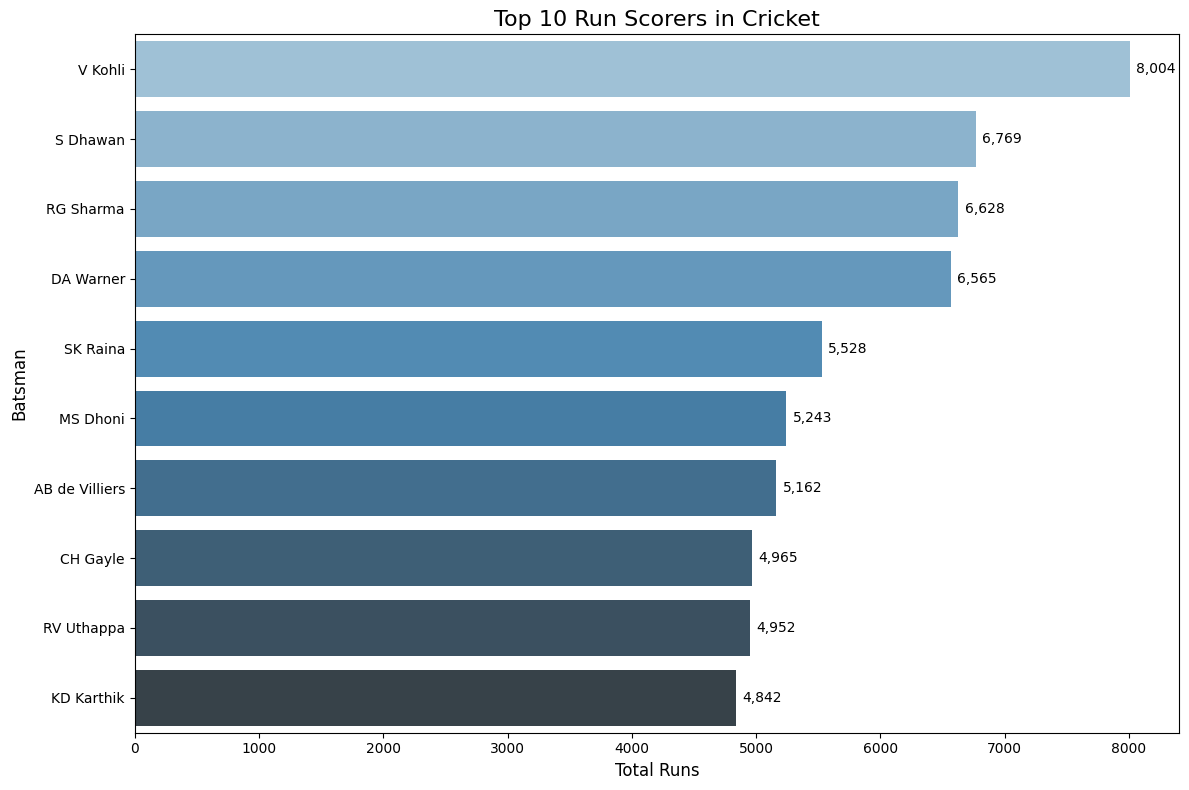

<Axes: title={'center': 'Top 10 Run Scorers in Cricket'}, xlabel='Total Runs', ylabel='Batsman'>

In [7]:
#Player wise analysis : top run scorers
def get_top_run_scorers(n=20):
    top_scorers = deliveries.groupby('batter')['batsman_runs'].sum().reset_index()
    return top_scorers.sort_values(by='batsman_runs', ascending=False).head(n)

def plot_top_run_scorers(n=20):
    top_scorers = get_top_run_scorers(n)

    plt.figure(figsize=(12, 8))

    ax = sns.barplot(
        data=top_scorers,
        y='batter',
        x='batsman_runs',
        palette='Blues_d'
    )

    plt.title(f'Top {n} Run Scorers in Cricket', fontsize=16)
    plt.xlabel('Total Runs', fontsize=12)
    plt.ylabel('Batsman', fontsize=12)

    for i, v in enumerate(top_scorers['batsman_runs']):
        ax.text(v + 50, i, f"{v:,}", va='center', fontsize=10)

    plt.tight_layout()
    plt.show()

    return ax

plot_top_run_scorers(n=10)


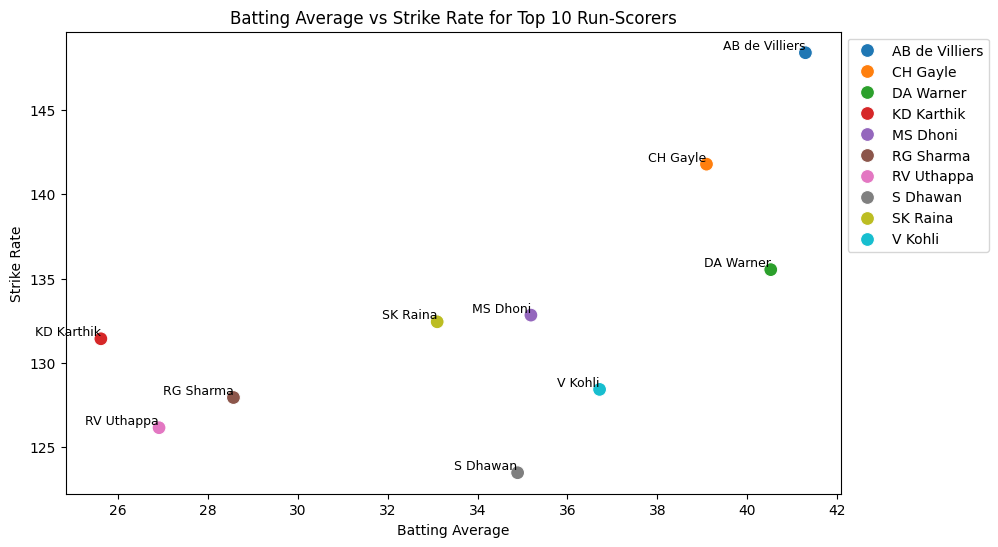

In [8]:
# Plots Batting Average vs Strike Rate for Top 20 Run-Scorers.
def plot_batting_avg_vs_strike_rate(n_ = 10):
    batting_stats = deliveries.groupby('batter').agg(
        total_runs=('batsman_runs', 'sum'),
        total_balls=('batsman_runs', 'count'),
        total_dismissals=('player_dismissed', 'count')
    ).reset_index()

    batting_stats['batting_average'] = batting_stats['total_runs'] / batting_stats['total_dismissals']
    batting_stats['strike_rate'] = (batting_stats['total_runs'] / batting_stats['total_balls']) * 100

    top_n_stats = batting_stats[batting_stats['batter'].isin(get_top_run_scorers(n=n_)['batter'])]

    plt.figure(figsize=(10, 6))
    sns.scatterplot(x='batting_average', y='strike_rate', data=top_n_stats, hue='batter', s=100)

    for i in range(top_n_stats.shape[0]):
        plt.text(
            top_n_stats['batting_average'].iloc[i],
            top_n_stats['strike_rate'].iloc[i],
            top_n_stats['batter'].iloc[i],
            fontsize=9, ha='right', va='bottom'
        )

    plt.xlabel("Batting Average")
    plt.ylabel("Strike Rate")
    plt.title("Batting Average vs Strike Rate for Top 10 Run-Scorers")
    plt.legend(bbox_to_anchor=(1,1))
    plt.show()

plot_batting_avg_vs_strike_rate(n_= 10)

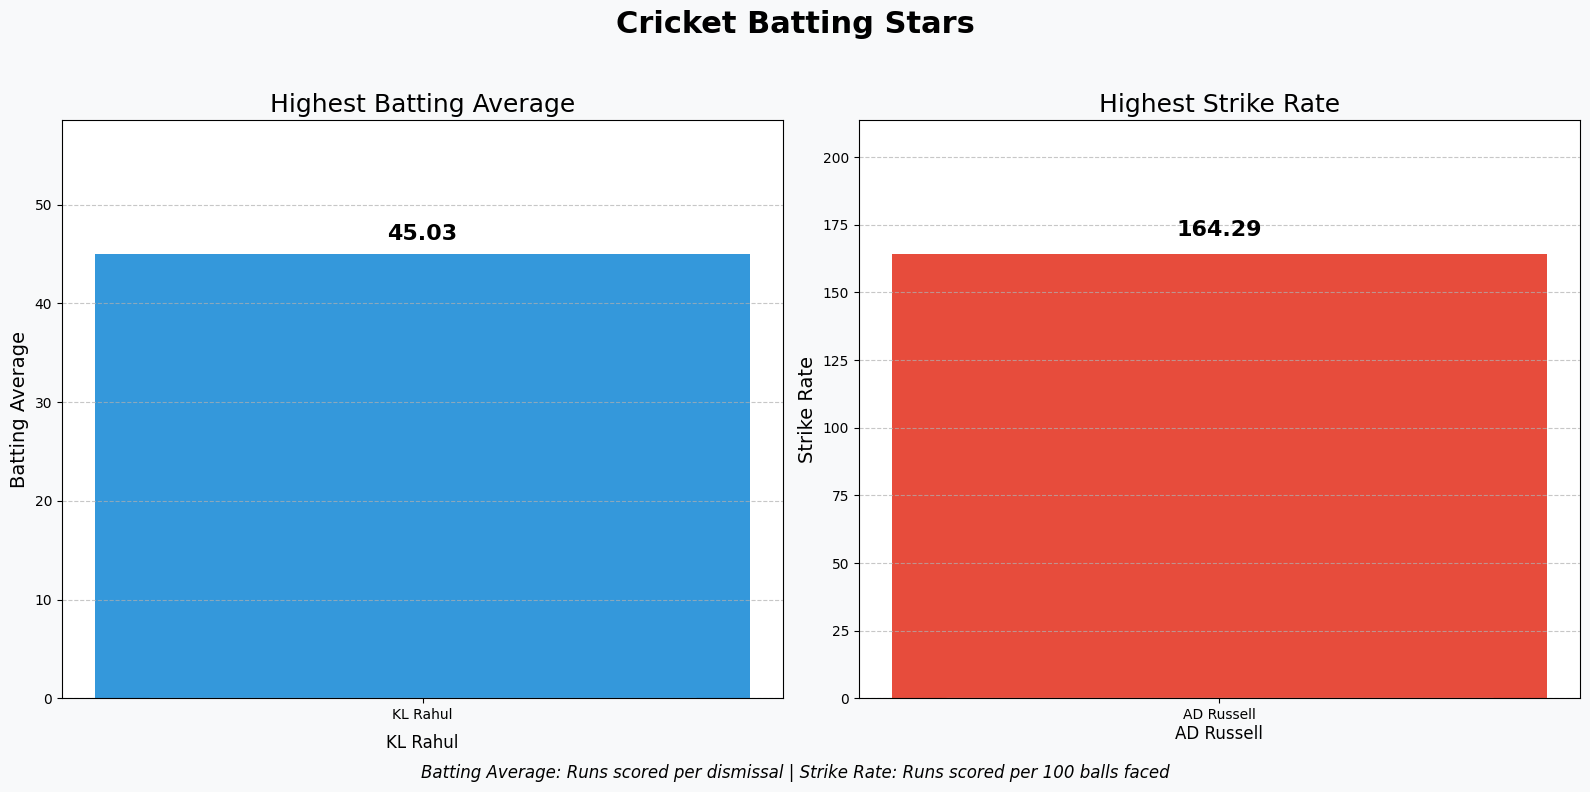

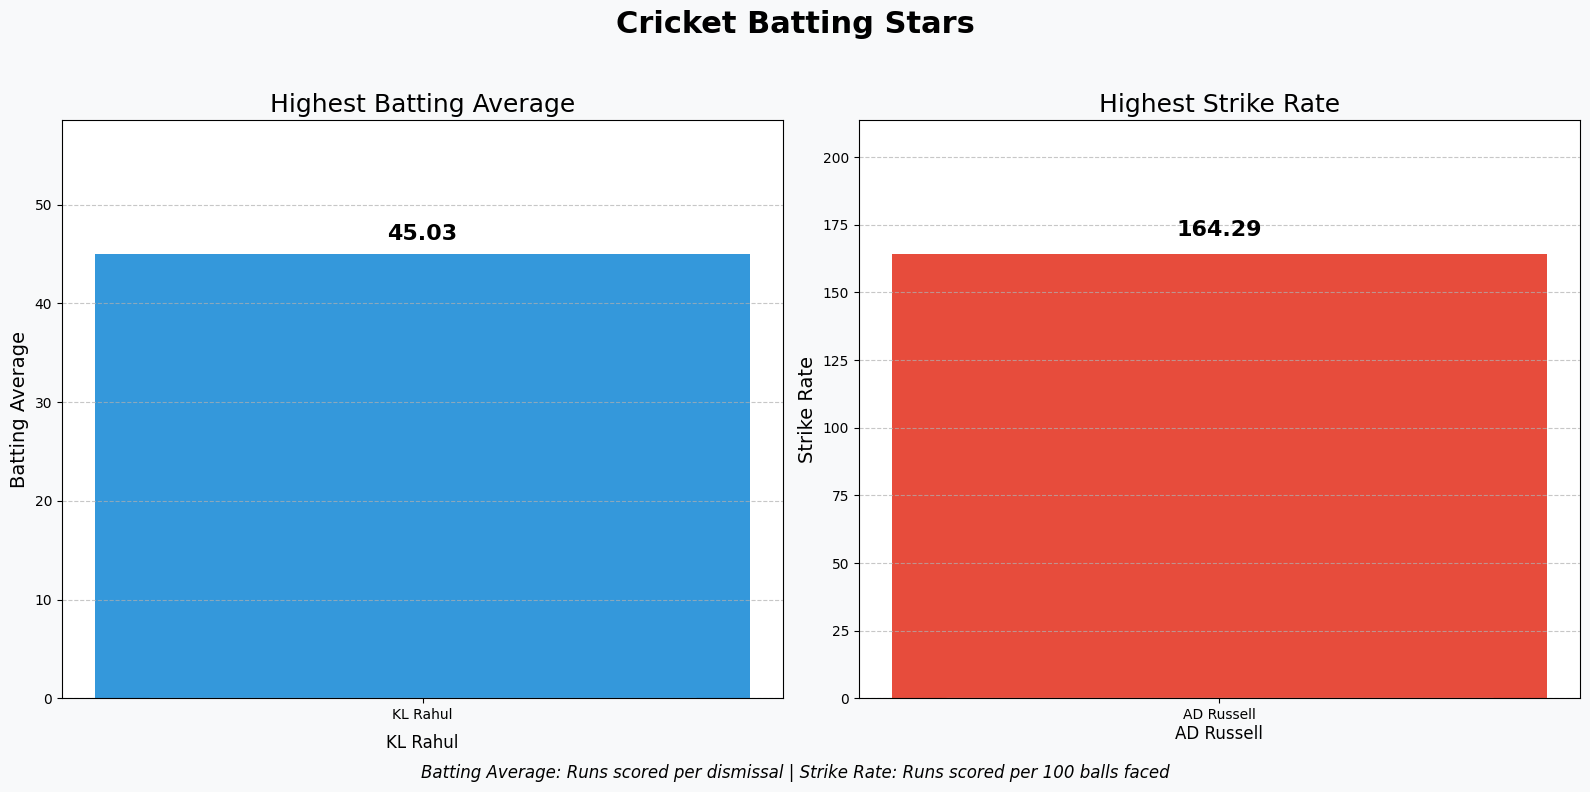

In [9]:

def visualize_cricket_stats():
    player_data = {
        'KL Rahul': {'stat_value': 45.03, 'stat_type': 'Batting Average'},
        'AD Russell': {'stat_value': 164.29, 'stat_type': 'Strike Rate'}
    }

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
    fig.suptitle('Cricket Batting Stars', fontsize=22, fontweight='bold')

    colors = ['#3498db', '#e74c3c']

    ax1.set_title('Highest Batting Average', fontsize=18)
    ax1.bar('KL Rahul', player_data['KL Rahul']['stat_value'], color=colors[0], width=0.6)
    ax1.text(0, player_data['KL Rahul']['stat_value'] + 1, f"{player_data['KL Rahul']['stat_value']}",
             ha='center', va='bottom', fontsize=16, fontweight='bold')
    ax1.set_ylim(0, player_data['KL Rahul']['stat_value'] * 1.3)
    ax1.set_ylabel('Batting Average', fontsize=14)
    ax1.grid(axis='y', linestyle='--', alpha=0.7)

    player_img = plt.Rectangle((-0.25, -10), 0.5, 10, fill=True, color='#f1f1f1', alpha=0.3)
    ax1.add_patch(player_img)
    ax1.text(0, -5, 'KL Rahul', ha='center', fontsize=12)

    ax2.set_title('Highest Strike Rate', fontsize=18)
    ax2.bar('AD Russell', player_data['AD Russell']['stat_value'], color=colors[1], width=0.6)
    ax2.text(0, player_data['AD Russell']['stat_value'] + 5, f"{player_data['AD Russell']['stat_value']}",
             ha='center', va='bottom', fontsize=16, fontweight='bold')
    ax2.set_ylim(0, player_data['AD Russell']['stat_value'] * 1.3)
    ax2.set_ylabel('Strike Rate', fontsize=14)
    ax2.grid(axis='y', linestyle='--', alpha=0.7)

    player_img = plt.Rectangle((-0.25, -30), 0.5, 30, fill=True, color='#f1f1f1', alpha=0.3)
    ax2.add_patch(player_img)
    ax2.text(0, -15, 'AD Russell', ha='center', fontsize=12)

    fig.text(0.5, 0.02,
             'Batting Average: Runs scored per dismissal | Strike Rate: Runs scored per 100 balls faced',
             ha='center', fontsize=12, style='italic')

    fig.patch.set_facecolor('#f8f9fa')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

    return fig

visualize_cricket_stats()


<ipython-input-10-93c13ebb7394>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='player_dismissed', y='bowler', data=top_wicket_takers, palette= "mako")


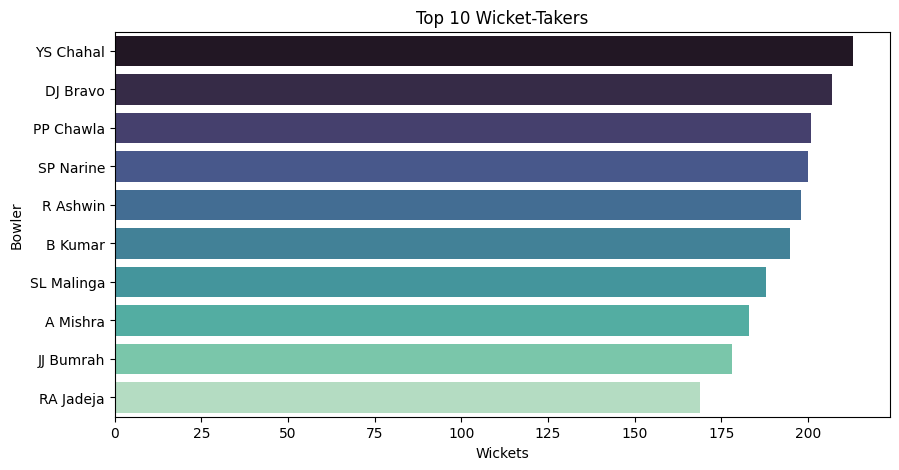

In [10]:
def plot_top_wicket_takers(n=10):
    """Plots the top wicket-takers."""
    top_wicket_takers = deliveries[deliveries['player_dismissed'].notna()].groupby('bowler')['player_dismissed'].count().reset_index()
    top_wicket_takers = top_wicket_takers.sort_values(by='player_dismissed', ascending=False).head(n)

    plt.figure(figsize=(10, 5))
    sns.barplot(x='player_dismissed', y='bowler', data=top_wicket_takers, palette= "mako")
    plt.xlabel("Wickets")
    plt.ylabel("Bowler")
    plt.title(f"Top {n} Wicket-Takers")
    plt.show()

plot_top_wicket_takers()

Plot saved as highest_scores.jpeg


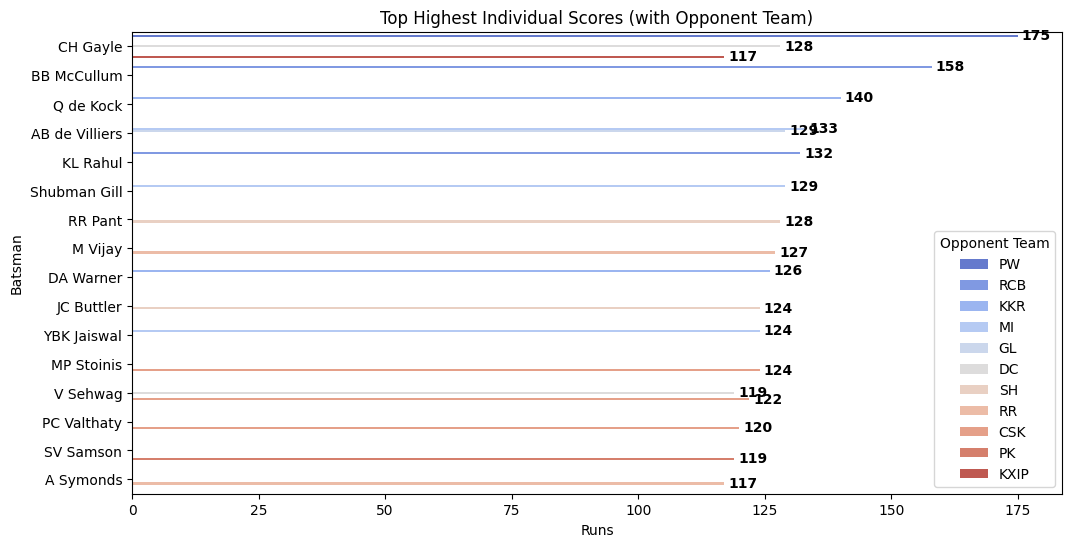

In [11]:
name_to_shortform = {
    'Mumbai Indians': 'MI',
    'Chennai Super Kings': 'CSK',
    'Royal Challengers Bangalore': 'RCB',
    'Sunrisers Hyderabad': 'SH',
    'Delhi Capitals': 'DC',
    'Kolkata Knight Riders': 'KKR',
    'Rajasthan Royals': 'RR',
    'Punjab Kings': 'PK',
    'Gujarat Titans': 'GT',
    'Lucknow Super Giants': 'LSG',
    'Delhi Daredevils': 'DC',
    'Kings XI Punjab': 'KXIP',
    'Deccan Chargers': 'DC',
    'Kochi Tuskers Kerala': 'KTK',
    'Pune Warriors': 'PW',
    'Rising Pune Supergiants': 'RPS',
    'Rising Pune Supergiant': 'RPS',
    'Gujarat Lions': 'GL'
}

def plot_highest_individual_scores(n=10, save_as="highest_scores.jpeg"):
    required_cols = ['match_id', 'batter', 'bowling_team', 'batsman_runs']
    data = deliveries[required_cols].copy()

    highest_scores = data.groupby(['match_id', 'batter', 'bowling_team'], as_index=False)['batsman_runs'].sum()
    top_scores = highest_scores.nlargest(n, 'batsman_runs')

    top_scores['bowling_team'] = top_scores['bowling_team'].map(name_to_shortform).fillna(top_scores['bowling_team'])

    plt.figure(figsize=(12, 6))
    ax = sns.barplot(data=top_scores, x='batsman_runs', y='batter', hue='bowling_team', dodge=True, palette="coolwarm")

    for container in ax.containers:
        ax.bar_label(container, fmt='%d', label_type='edge', padding=3, fontsize=10, fontweight='bold')

    plt.xlabel("Runs")
    plt.ylabel("Batsman")
    plt.title("Top Highest Individual Scores (with Opponent Team)")
    plt.legend(title="Opponent Team", loc='lower right')

    plt.savefig(save_as, format='jpeg', dpi=200, bbox_inches='tight')

    print(f"Plot saved as {save_as}")

plot_highest_individual_scores(n=20, save_as="highest_scores.jpeg")


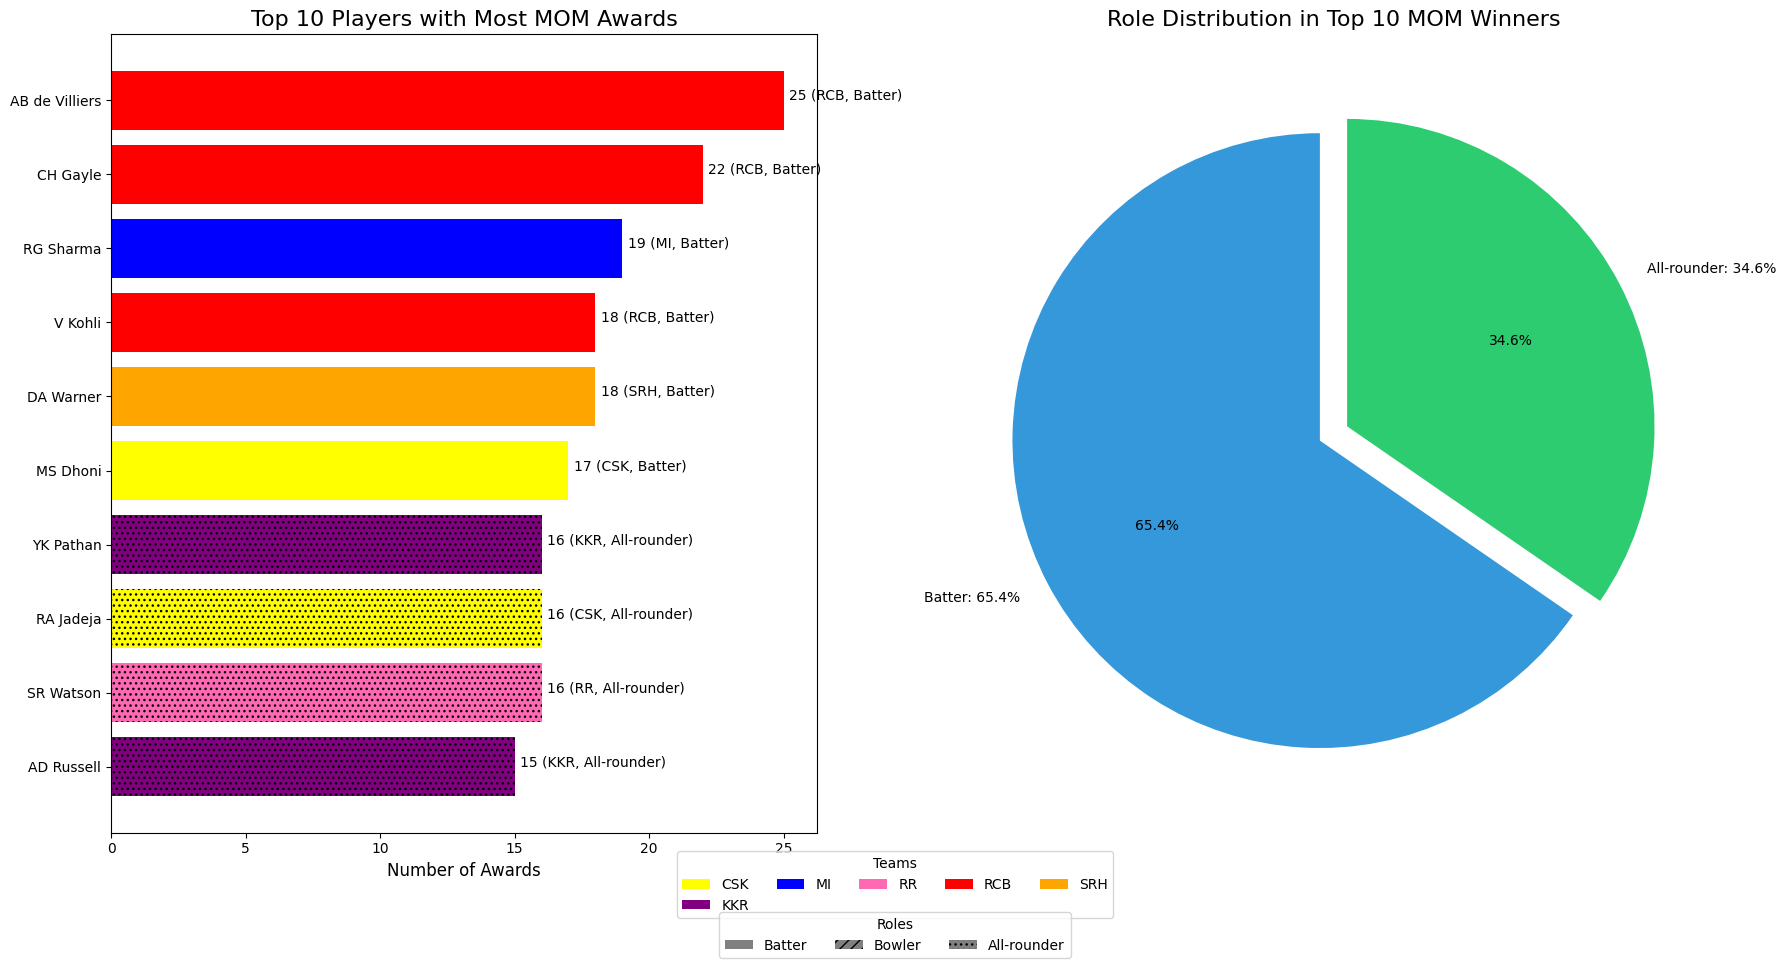

In [14]:
from matplotlib.patches import Patch

team_colors = {
    'CSK': '#FFFF00', 'DC': '#0080FF', 'DEC': '#D4AF37', 'PBKS': '#FF0000',
    'KKR': '#800080', 'MI': '#0000FF', 'RR': '#FF69B4', 'RCB': '#FF0000',
    'SRH': '#FFA500', 'PW': '#800080', 'KTK': '#FFA500', 'GL': '#FFA500',
    'RPS': '#800080', 'LSG': '#87CEEB', 'GT': '#0000FF'
}

player_categories = {
    'CH Gayle': {'role': 'Batter', 'primary_team': 'RCB'},
    'V Kohli': {'role': 'Batter', 'primary_team': 'RCB'},
    'DA Warner': {'role': 'Batter', 'primary_team': 'SRH'},
    'RG Sharma': {'role': 'Batter', 'primary_team': 'MI'},
    'AB de Villiers': {'role': 'Batter', 'primary_team': 'RCB'},
    'MS Dhoni': {'role': 'Batter', 'primary_team': 'CSK'},
    'JC Buttler': {'role': 'Batter', 'primary_team': 'RR'},
    'AM Rahane': {'role': 'Batter', 'primary_team': 'KKR'},
    'SK Raina': {'role': 'Batter', 'primary_team': 'CSK'},
    'S Dhawan': {'role': 'Batter', 'primary_team': 'DC'},
    'KL Rahul': {'role': 'Batter', 'primary_team': 'PBKS'},
    'F du Plessis': {'role': 'Batter', 'primary_team': 'CSK'},
    'SL Malinga': {'role': 'Bowler', 'primary_team': 'MI'},
    'SP Narine': {'role': 'Bowler', 'primary_team': 'KKR'},
    'B Kumar': {'role': 'Bowler', 'primary_team': 'SRH'},
    'JJ Bumrah': {'role': 'Bowler', 'primary_team': 'MI'},
    'YS Chahal': {'role': 'Bowler', 'primary_team': 'RCB'},
    'A Mishra': {'role': 'Bowler', 'primary_team': 'DC'},
    'R Ashwin': {'role': 'Bowler', 'primary_team': 'CSK'},
    'UT Yadav': {'role': 'Bowler', 'primary_team': 'KKR'},
    'PP Chawla': {'role': 'Bowler', 'primary_team': 'CSK'},
    'Mohammed Shami': {'role': 'Bowler', 'primary_team': 'PBKS'},
    'Harbhajan Singh': {'role': 'Bowler', 'primary_team': 'MI'},
    'SR Watson': {'role': 'All-rounder', 'primary_team': 'RR'},
    'YK Pathan': {'role': 'All-rounder', 'primary_team': 'KKR'},
    'Yuvraj Singh': {'role': 'All-rounder', 'primary_team': 'PBKS'},
    'RA Jadeja': {'role': 'All-rounder', 'primary_team': 'CSK'},
    'AD Russell': {'role': 'All-rounder', 'primary_team': 'KKR'},
    'DJ Bravo': {'role': 'All-rounder', 'primary_team': 'CSK'},
    'HH Pandya': {'role': 'All-rounder', 'primary_team': 'MI'},
    'KA Pollard': {'role': 'All-rounder', 'primary_team': 'MI'},
    'GJ Maxwell': {'role': 'All-rounder', 'primary_team': 'RCB'},
    'BCJ Cutting': {'role': 'All-rounder', 'primary_team': 'MI'},
    'JC Archer': {'role': 'All-rounder', 'primary_team': 'RR'}
}

def get_player_info(player_name):
    return player_categories.get(player_name, {'role': 'Unknown', 'primary_team': 'Unknown'})

all_mom_winners = df['player_of_match'].dropna().value_counts()
top10_mom = all_mom_winners.head(10)

plt.figure(figsize=(18, 10))
plt.subplot(1, 2, 1)
colors = [team_colors.get(get_player_info(player)['primary_team'], 'gray') for player in top10_mom.index]
roles = [get_player_info(player)['role'] for player in top10_mom.index]

hatches = ['' if role == 'Batter' else '///' if role == 'Bowler' else '...' for role in roles]
bars = plt.barh(top10_mom.index, top10_mom.values, color=colors)

for bar, hatch in zip(bars, hatches):
    bar.set_hatch(hatch)

plt.title('Top 10 Players with Most MOM Awards', fontsize=16)
plt.xlabel('Number of Awards', fontsize=12)
plt.gca().invert_yaxis()

for i, (player, count) in enumerate(top10_mom.items()):
    team = get_player_info(player)['primary_team']
    role = get_player_info(player)['role']
    plt.text(count + 0.2, i, f"{count} ({team}, {role})", fontsize=10)

plt.subplot(1, 2, 2)
role_counts = {'Batter': 0, 'Bowler': 0, 'All-rounder': 0, 'Unknown': 0}
for player in top10_mom.index:
    role_counts[get_player_info(player)['role']] += top10_mom[player]

total_awards = sum(role_counts.values())
role_percentages = {role: (count / total_awards) * 100 for role, count in role_counts.items() if count > 0}
role_colors = {'Batter': '#3498db', 'Bowler': '#e74c3c', 'All-rounder': '#2ecc71', 'Unknown': '#95a5a6'}

plt.pie(role_percentages.values(), labels=[f"{role}: {percent:.1f}%" for role, percent in role_percentages.items()],
        colors=[role_colors[role] for role in role_percentages.keys()], autopct='%1.1f%%', startangle=90,
        explode=[0.05] * len(role_percentages))
plt.title('Role Distribution in Top 10 MOM Winners', fontsize=16)
plt.axis('equal')

team_patches = [Patch(facecolor=color, label=team) for team, color in team_colors.items()
                if team in [get_player_info(player)['primary_team'] for player in top10_mom.index]]

role_patches = [Patch(facecolor='gray', label='Batter'),
                Patch(facecolor='gray', hatch='///', label='Bowler'),
                Patch(facecolor='gray', hatch='...', label='All-rounder')]

plt.figlegend(handles=team_patches, title="Teams", loc='lower center', ncol=5, bbox_to_anchor=(0.5, 0.02))
plt.figlegend(handles=role_patches, title="Roles", loc='lower center', ncol=3, bbox_to_anchor=(0.5, -0.02))
plt.tight_layout(rect=[0, 0.05, 1, 0.95])
plt.show()


<ipython-input-20-b8631f333989>:132: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0.05, 0.05, 0.95, 0.92])


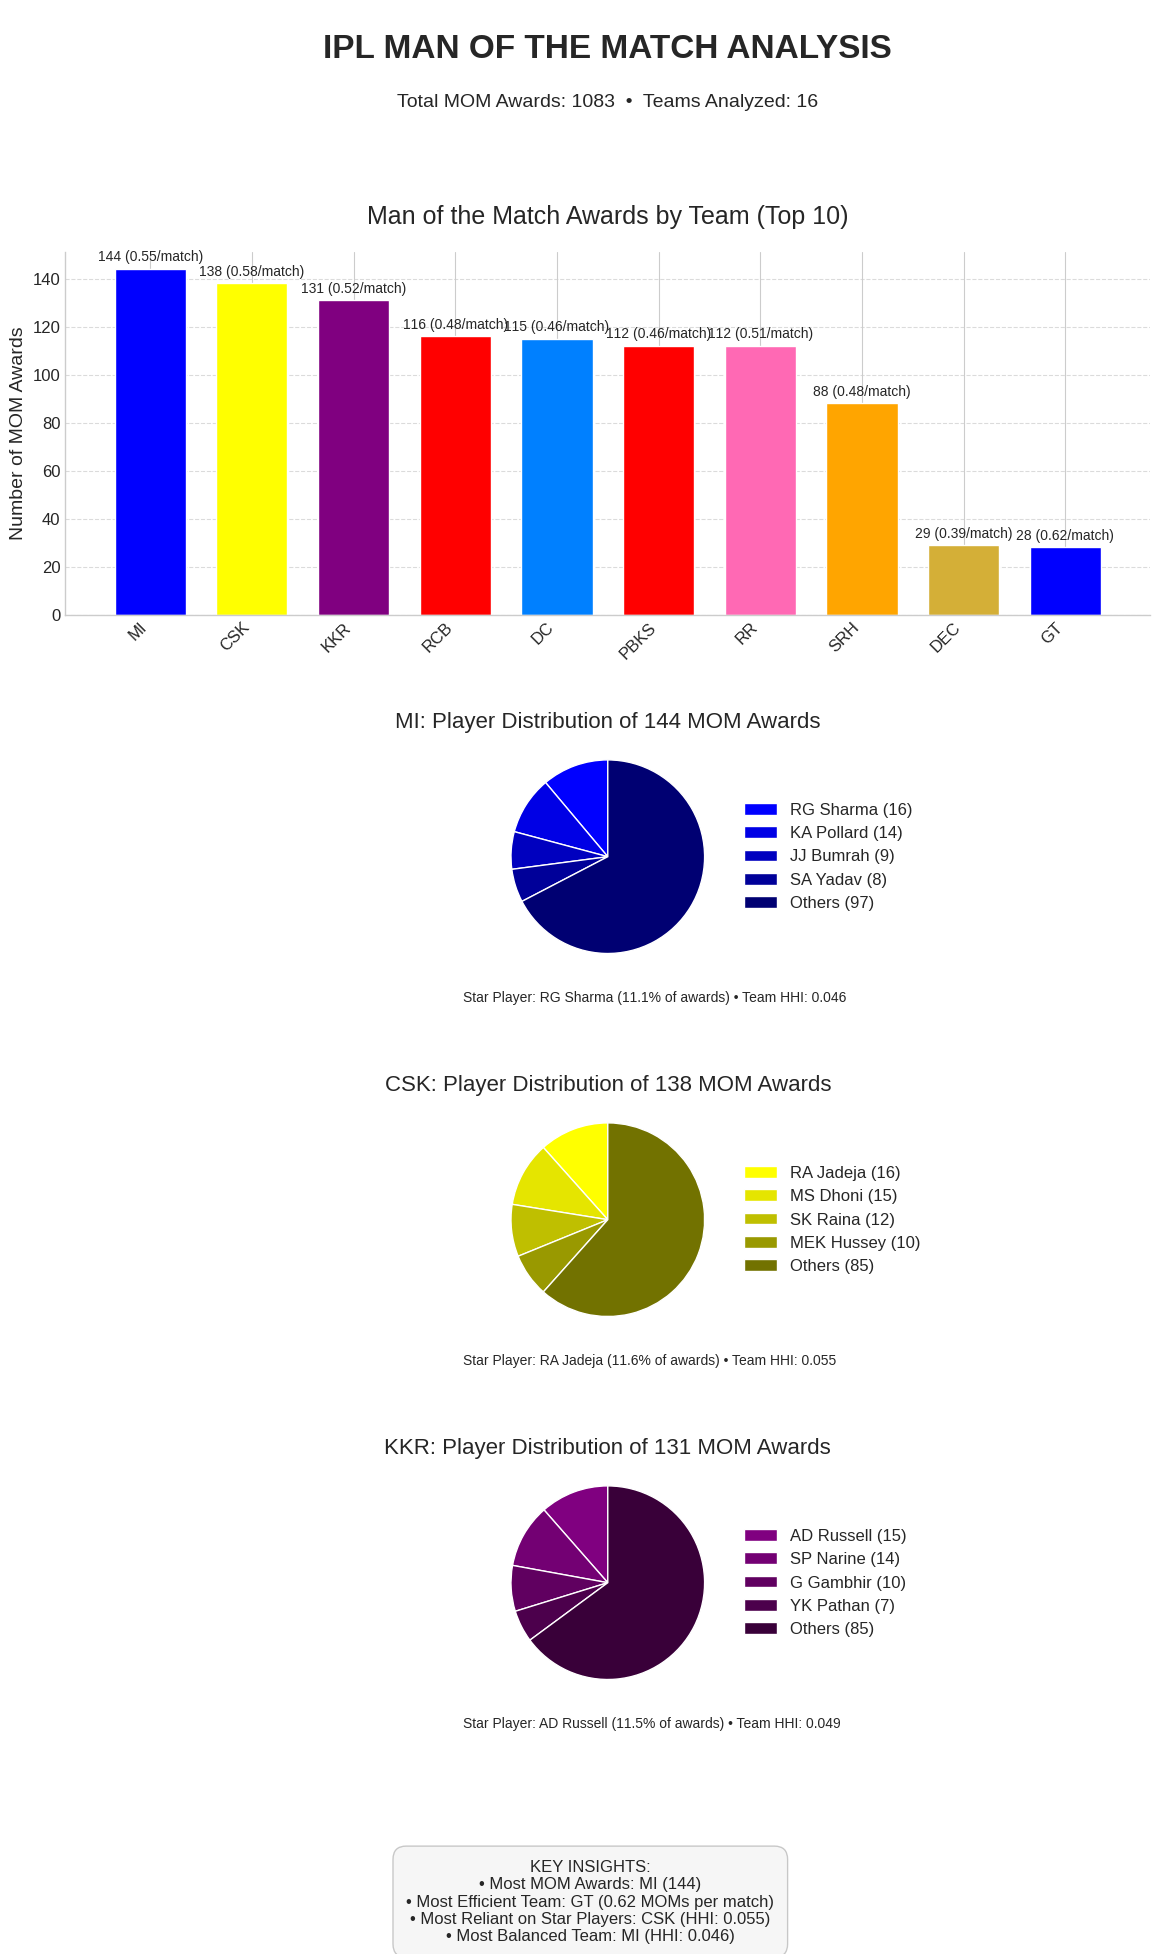

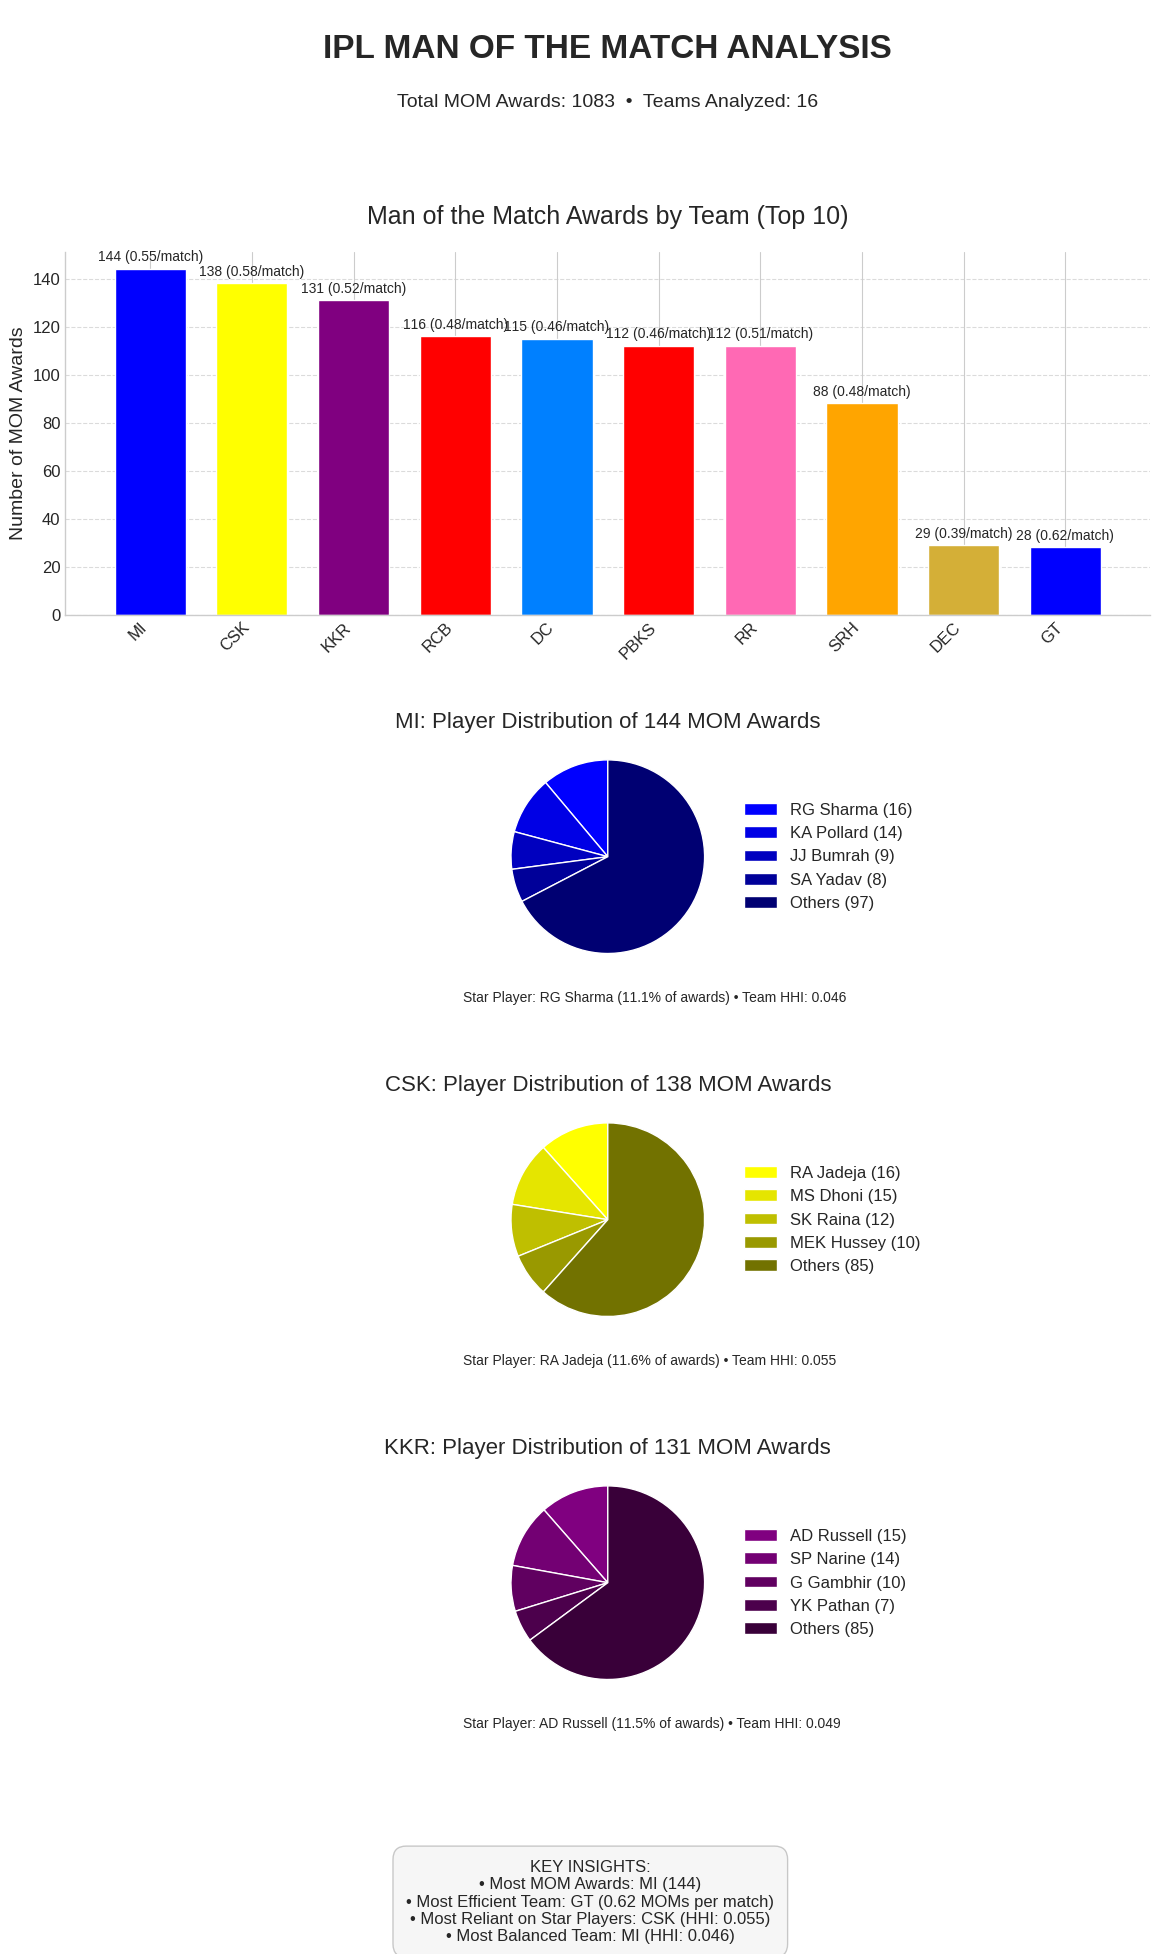

In [20]:
def adjust_color_brightness(color_hex, factor=0.8):
    color_hex = color_hex.lstrip('#')
    rgb = tuple(int(color_hex[i:i+2], 16) for i in (0, 2, 4))
    h, s, v = colorsys.rgb_to_hsv(rgb[0]/255, rgb[1]/255, rgb[2]/255)
    v = min(1.0, v * factor)
    r, g, b = colorsys.hsv_to_rgb(h, s, v)
    return f"#{int(r*255):02x}{int(g*255):02x}{int(b*255):02x}"

def create_fixed_ipl_dashboard(df, team_colors):
    match_winners = df[['id', 'winner']].set_index('id').to_dict()['winner']
    mom_data = df[['id', 'player_of_match']].dropna()
    mom_data['winning_team'] = mom_data['id'].map(match_winners)
    all_mom_teams = mom_data.groupby('winning_team').size().sort_values(ascending=False)
    top_mom_teams = all_mom_teams.head(3)
    total_matches_by_team = {}

    for team in df['team1'].unique():
        matches_as_team1 = df[df['team1'] == team].shape[0]
        matches_as_team2 = df[df['team2'] == team].shape[0]
        total_matches_by_team[team] = matches_as_team1 + matches_as_team2

    mom_efficiency = {}
    for team in all_mom_teams.index:
        if team in total_matches_by_team and total_matches_by_team[team] > 0:
            mom_efficiency[team] = all_mom_teams[team] / total_matches_by_team[team]
        else:
            mom_efficiency[team] = 0

    team_concentration_index = {}
    most_dependent_team = ('', 0)
    most_diverse_team = ('', 1)

    plt.style.use('seaborn-v0_8-whitegrid')
    plt.rcParams.update({'font.size': 12})

    fig = plt.figure(figsize=(14, 22))
    gs = gridspec.GridSpec(5, 1, figure=fig, height_ratios=[0.5, 1.5, 1, 1, 1], hspace=0.5)

    ax_title = fig.add_subplot(gs[0])
    ax_title.axis('off')
    ax_title.text(0.5, 0.6, 'IPL MAN OF THE MATCH ANALYSIS', fontsize=24, fontweight='bold', ha='center')
    total_moms = all_mom_teams.sum()
    ax_title.text(0.5, 0.2, f'Total MOM Awards: {total_moms}  •  Teams Analyzed: {len(total_matches_by_team)}', fontsize=14, ha='center')

    ax_main = fig.add_subplot(gs[1])
    top10_mom_teams = all_mom_teams.head(10)
    team_indices = range(len(top10_mom_teams))
    bars = ax_main.bar(
        team_indices,
        top10_mom_teams.values,
        color=[team_colors.get(team, '#CCCCCC') for team in top10_mom_teams.index],
        edgecolor='white',
        linewidth=1,
        width=0.7
    )

    for i, (team, count) in enumerate(top10_mom_teams.items()):
        efficiency = mom_efficiency.get(team, 0)
        ax_main.text(
            i, count + 2,
            f"{count} ({efficiency:.2f}/match)",
            ha='center',
            va='bottom',
            fontsize=10
        )

    ax_main.set_title('Man of the Match Awards by Team (Top 10)', fontsize=18, pad=20)
    ax_main.set_ylabel('Number of MOM Awards', fontsize=14)
    ax_main.set_xticks(team_indices)
    ax_main.set_xticklabels(top10_mom_teams.index, rotation=45, ha='right')
    ax_main.yaxis.grid(True, linestyle='--', alpha=0.7)
    ax_main.set_axisbelow(True)
    ax_main.spines['top'].set_visible(False)
    ax_main.spines['right'].set_visible(False)

    for i, (team, total_moms) in enumerate(top_mom_teams.items()):
        ax_pie = fig.add_subplot(gs[i+2])
        team_moms = mom_data[mom_data['winning_team'] == team]
        player_moms = team_moms.groupby('player_of_match').size().sort_values(ascending=False)
        herfindahl_index = sum((count/total_moms)**2 for count in player_moms)
        team_concentration_index[team] = herfindahl_index

        if herfindahl_index > most_dependent_team[1]:
            most_dependent_team = (team, herfindahl_index)
        if herfindahl_index < most_diverse_team[1]:
            most_diverse_team = (team, herfindahl_index)

        if len(player_moms) > 5:
            main_players = player_moms.head(4)
            others_count = player_moms.iloc[4:].sum()
            plot_data = main_players.copy()
            plot_data['Others'] = others_count
        else:
            plot_data = player_moms

        team_color = team_colors.get(team, '#CCCCCC')
        colors = [team_color] + [adjust_color_brightness(team_color, factor=0.9-j*0.15) for j in range(len(plot_data)-1)]
        wedges, texts = ax_pie.pie(
            plot_data.values,
            colors=colors,
            wedgeprops={'edgecolor': 'white', 'linewidth': 1},
            startangle=90,
        )

        ax_pie.set_title(f"{team}: Player Distribution of {total_moms} MOM Awards", fontsize=16)
        ax_pie.legend(
            wedges,
            [f"{player} ({count})" for player, count in plot_data.items()],
            loc="center left",
            bbox_to_anchor=(1.0, 0.5),
            fontsize=12
        )

        top_player_pct = (player_moms.iloc[0] / total_moms) * 100
        ax_pie.text(
            -0.1, -0.1,
            f"Star Player: {player_moms.index[0]} ({top_player_pct:.1f}% of awards) • Team HHI: {herfindahl_index:.3f}",
            transform=ax_pie.transAxes,
            fontsize=10
        )

    top_efficient = sorted(mom_efficiency.items(), key=lambda x: x[1], reverse=True)[0]
    insights_text = (
        f"KEY INSIGHTS:\n"
        f"• Most MOM Awards: {all_mom_teams.index[0]} ({all_mom_teams.iloc[0]})\n"
        f"• Most Efficient Team: {top_efficient[0]} ({top_efficient[1]:.2f} MOMs per match)\n"
        f"• Most Reliant on Star Players: {most_dependent_team[0]} (HHI: {most_dependent_team[1]:.3f})\n"
        f"• Most Balanced Team: {most_diverse_team[0]} (HHI: {most_diverse_team[1]:.3f})"
    )

    fig.text(0.5, 0.02, insights_text, ha='center', va='center', fontsize=12, bbox=dict(boxstyle="round,pad=0.8", facecolor='lightgray', alpha=0.2))
    plt.tight_layout(rect=[0.05, 0.05, 0.95, 0.92])

    return fig

create_fixed_ipl_dashboard(df, team_colors)

Top 10 Batsmen with Most 6s:
             batter  number_of_sixes
84         CH Gayle              357
324       RG Sharma              281
427         V Kohli              273
254        MS Dhoni              252
14   AB de Villiers              251
98        DA Warner              236
184      KA Pollard              223
23       AD Russell              209
387       SV Samson              206
365        SK Raina              203

Top 10 Batsmen with Most 4s:
           batter  number_of_fours
416      S Dhawan              768
508       V Kohli              706
119     DA Warner              663
388     RG Sharma              599
441      SK Raina              506
158     G Gambhir              492
406    RV Uthappa              481
43      AM Rahane              479
230    KD Karthik              466
155  F du Plessis              422

Top 10 Batsmen with Most 2s:
             batter  number_of_twos
490         V Kohli             445
120       DA Warner             370
297        

<ipython-input-21-a5b79683064d>:50: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
<ipython-input-21-a5b79683064d>:50: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
<ipython-input-21-a5b79683064d>:50: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
<ipython-input-21-a5b79683064d>:50: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


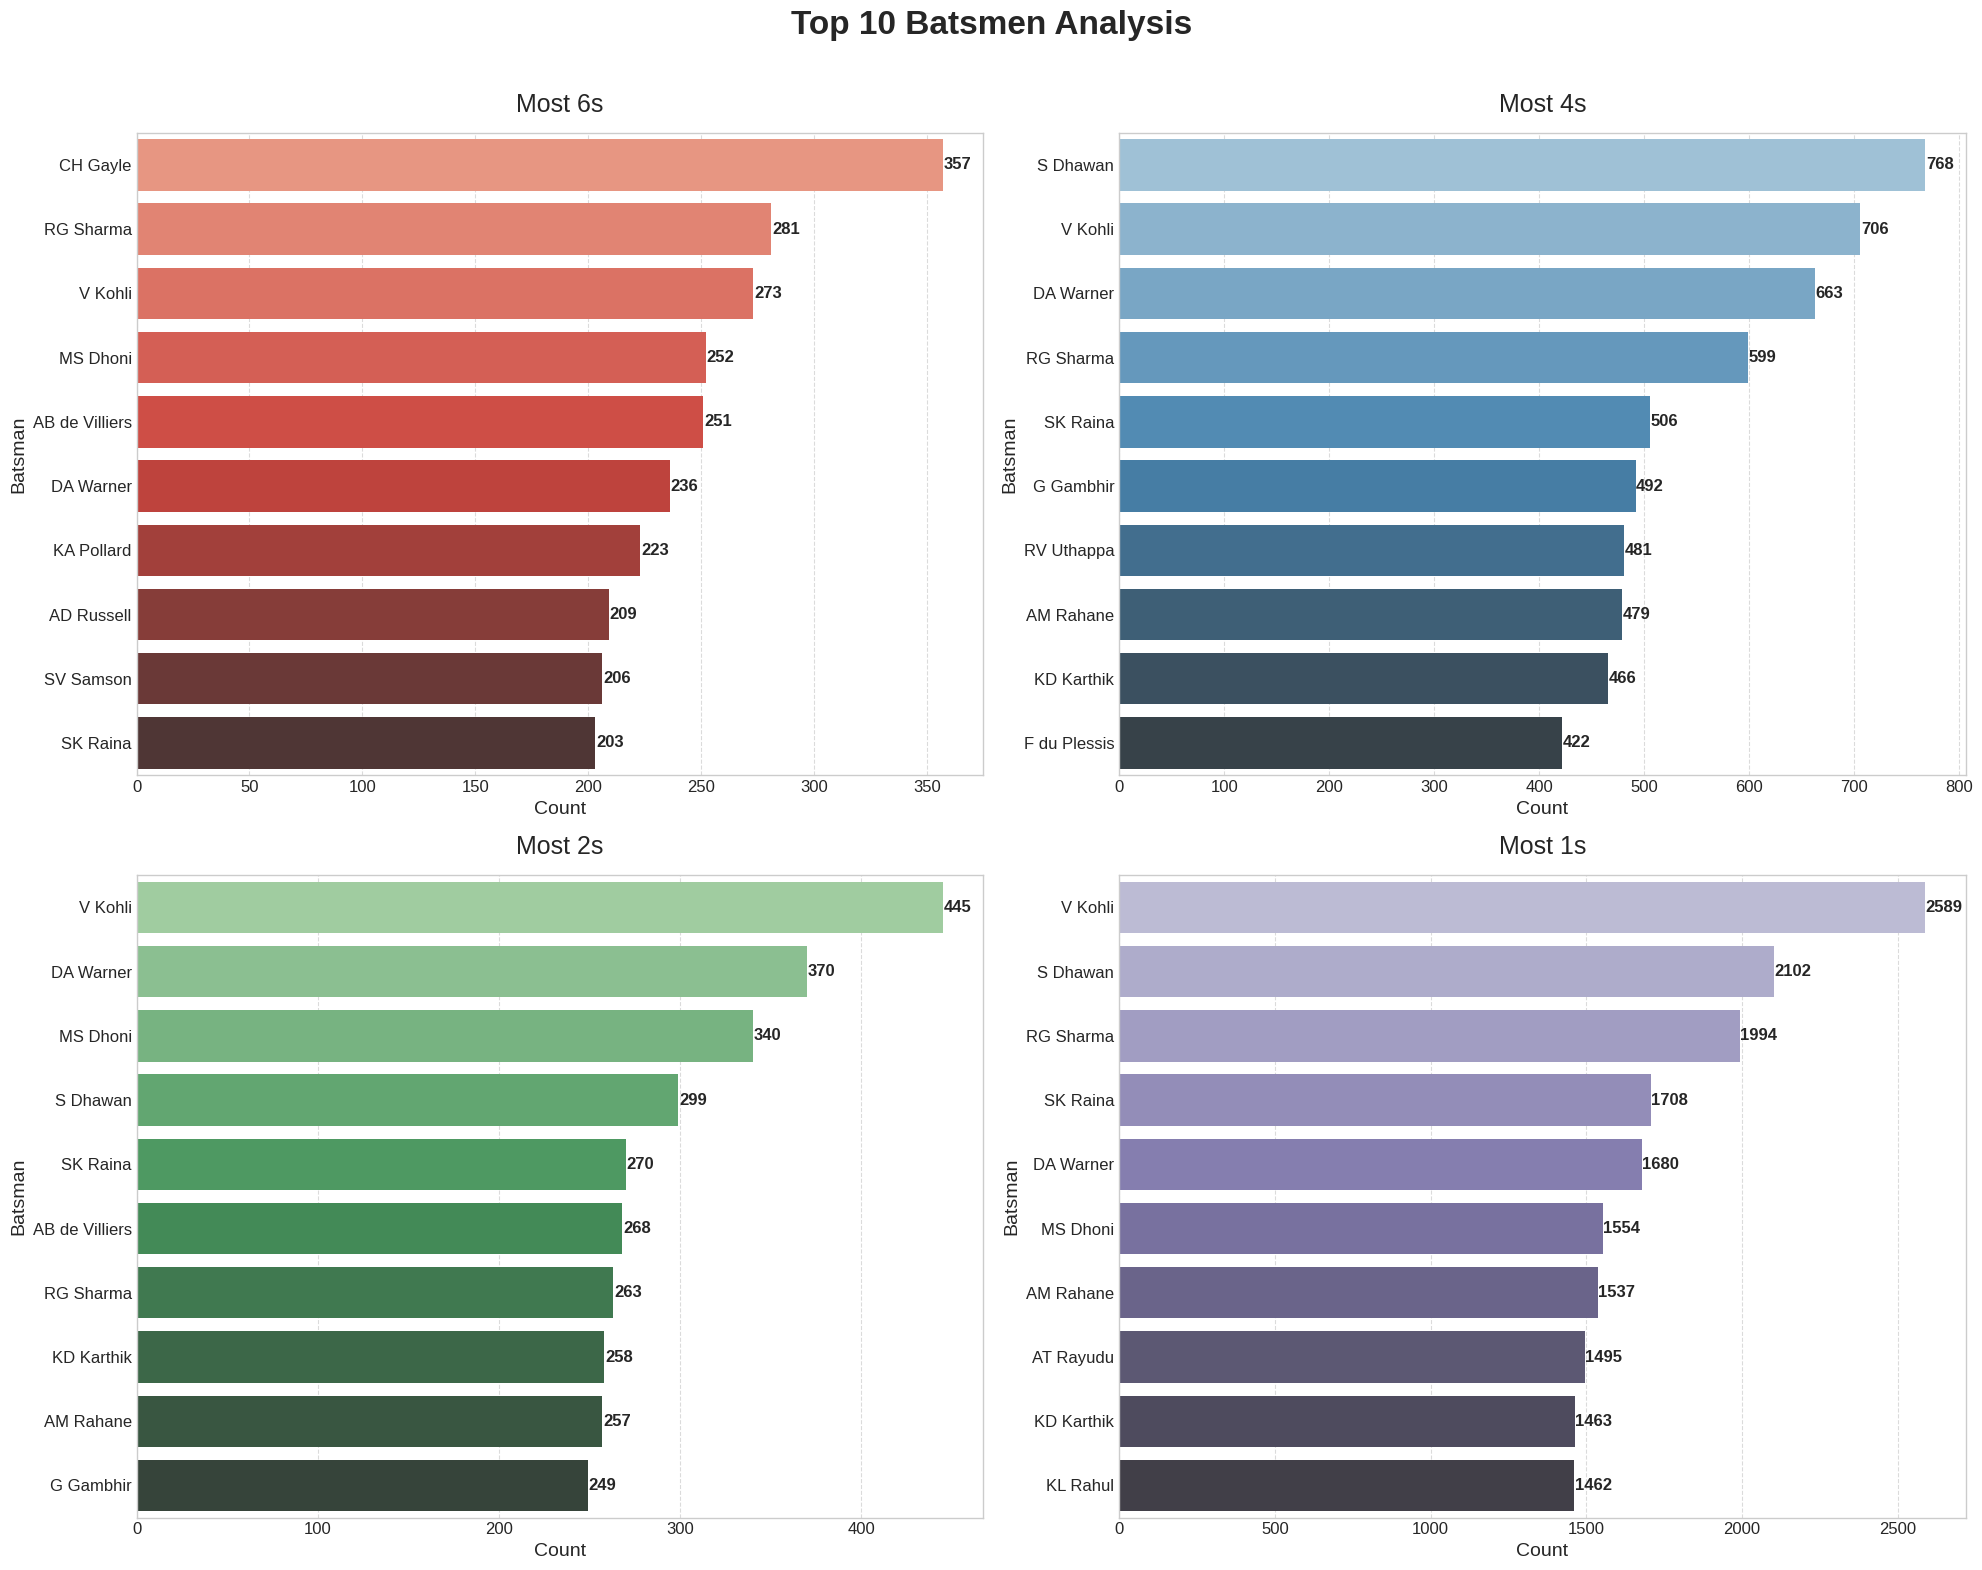

In [21]:

def analyze_top_batsmen(deliveries):
    top_batsmen = {}

    sixes = deliveries[deliveries['batsman_runs'] == 6].groupby('batter').size().reset_index()
    sixes.columns = ['batter', 'number_of_sixes']
    top_batsmen['sixes'] = sixes.sort_values('number_of_sixes', ascending=False).head(10)

    fours = deliveries[deliveries['batsman_runs'] == 4].groupby('batter').size().reset_index()
    fours.columns = ['batter', 'number_of_fours']
    top_batsmen['fours'] = fours.sort_values('number_of_fours', ascending=False).head(10)

    twos = deliveries[deliveries['batsman_runs'] == 2].groupby('batter').size().reset_index()
    twos.columns = ['batter', 'number_of_twos']
    top_batsmen['twos'] = twos.sort_values('number_of_twos', ascending=False).head(10)

    ones = deliveries[deliveries['batsman_runs'] == 1].groupby('batter').size().reset_index()
    ones.columns = ['batter', 'number_of_ones']
    top_batsmen['ones'] = ones.sort_values('number_of_ones', ascending=False).head(10)

    return top_batsmen

def plot_top_batsmen(top_batsmen):
    fig, axes = plt.subplots(2, 2, figsize=(20, 16))
    fig.suptitle('Top 10 Batsmen Analysis', fontsize=24, fontweight='bold', y=0.98)

    color_palettes = {
        'sixes': 'Reds_d',
        'fours': 'Blues_d',
        'twos': 'Greens_d',
        'ones': 'Purples_d'
    }

    titles = {
        'sixes': 'Most 6s',
        'fours': 'Most 4s',
        'twos': 'Most 2s',
        'ones': 'Most 1s'
    }

    columns = {
        'sixes': 'number_of_sixes',
        'fours': 'number_of_fours',
        'twos': 'number_of_twos',
        'ones': 'number_of_ones'
    }

    for i, (category, ax) in enumerate(zip(top_batsmen.keys(), axes.flatten())):
        data = top_batsmen[category]

        sns.barplot(
            data=data,
            y='batter',
            x=columns[category],
            palette=color_palettes[category],
            ax=ax
        )

        ax.set_title(titles[category], fontsize=18, pad=15)
        ax.set_xlabel('Count', fontsize=14)
        ax.set_ylabel('Batsman', fontsize=14)

        for j, v in enumerate(data[columns[category]]):
            ax.text(v + 0.5, j, str(v), va='center', fontsize=12, fontweight='bold')

        ax.grid(axis='x', linestyle='--', alpha=0.7)

    plt.tight_layout(rect=[0, 0, 1, 0.97])
    return fig

def run_complete_analysis(deliveries):
    top_batsmen = analyze_top_batsmen(deliveries)

    print("Top 10 Batsmen with Most 6s:")
    print(top_batsmen['sixes'])
    print("\nTop 10 Batsmen with Most 4s:")
    print(top_batsmen['fours'])
    print("\nTop 10 Batsmen with Most 2s:")
    print(top_batsmen['twos'])
    print("\nTop 10 Batsmen with Most 1s:")
    print(top_batsmen['ones'])

    plot_fig = plot_top_batsmen(top_batsmen)
    plt.show()

    return top_batsmen, plot_fig

top_batsmen, plot_fig = run_complete_analysis(deliveries)


In [23]:

df['year'] = pd.to_datetime(df['date'], dayfirst=True).dt.year
deliveries = deliveries.merge(df[['id', 'year']], left_on='match_id', right_on='id')

total_runs_per_match = deliveries.groupby(['match_id', 'year'])['total_runs'].sum().reset_index()
avg_runs_per_match = total_runs_per_match.groupby('year')['total_runs'].mean().reset_index()
avg_runs_per_match.rename(columns={'total_runs': 'avg_runs_per_match'}, inplace=True)

fig = go.Figure(go.Scatter(
    x=avg_runs_per_match['year'],
    y=avg_runs_per_match['avg_runs_per_match'],
    mode='lines+markers',
    line=dict(color='darkblue', width=3),
    marker=dict(size=10, color='orange'),
    name='Avg Runs per Match'
))

fig.add_vline(x=2023, line_dash="dash", line_color="red", annotation_text="Impact Player Rule Introduced", annotation_position="top right")

fig.update_layout(
    title='Average Runs Per Match Over Seasons',
    xaxis_title='Season',
    yaxis_title='Average Runs per Match',
    template='plotly_white'
)

fig.show()


<ipython-input-23-76f0099d6dcd>:1: UserWarning: Parsing dates in %Y-%m-%d format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  df['year'] = pd.to_datetime(df['date'], dayfirst=True).dt.year


In [27]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go

# Load the actual data from matches.csv
df = pd.read_csv('matches.csv')

# Create proper season labels
df['season'] = pd.to_datetime(df['date']).dt.year
df['season'] = df['season'].apply(lambda x: f'{x}')  # Simplified year format

# Determine which team batted first based on toss information
df['batting_first'] = df.apply(
    lambda row: row['toss_winner'] if row['toss_decision'] == 'bat' else
    (row['team1'] if row['toss_winner'] == row['team2'] else row['team2']),
    axis=1
)

# Use team shortnames if available
team_shortnames = {
    'Mumbai Indians': 'MI',
    'Chennai Super Kings': 'CSK',
    'Royal Challengers Bangalore': 'RCB',
    'Royal Challengers Bengaluru': 'RCB',
    'Kolkata Knight Riders': 'KKR',
    'Delhi Capitals': 'DC',
    'Delhi Daredevils': 'DC',
    'Punjab Kings': 'PBKS',
    'Kings XI Punjab': 'PBKS',
    'Sunrisers Hyderabad': 'SRH',
    'Rajasthan Royals': 'RR',
    'Gujarat Titans': 'GT',
    'Lucknow Super Giants': 'LSG',
    'Rising Pune Supergiant': 'RPS',
    'Gujarat Lions': 'GL',
    'Deccan Chargers': 'DEC',
    'Kochi Tuskers Kerala': 'KTK',
    'Pune Warriors': 'PWI'
}

# Apply shortnames if column contains full names, otherwise leave as is
if df['batting_first'].iloc[0] in team_shortnames:
    df['batting_first'] = df['batting_first'].map(team_shortnames).fillna(df['batting_first'])

# Filter for target_runs >= 200
targets_200 = df[df['target_runs'] >= 200]

# Count of 200+ targets per season
targets_200_per_season = targets_200.groupby('season').size().reset_index(name='count')
targets_200_per_season = targets_200_per_season.sort_values('season')

# Which team set most 200+ runs target per season
team_targets_per_season = targets_200.groupby(['season', 'batting_first']).size().reset_index(name='count')
top_team_per_season = team_targets_per_season.loc[team_targets_per_season.groupby('season')['count'].idxmax()]

# Calculate team improvement after IPL 2023 (Impact Player rule)
pre_2023 = team_targets_per_season[~team_targets_per_season['season'].str.contains('2023|2024')]
post_2023 = team_targets_per_season[team_targets_per_season['season'].str.contains('2023|2024')]

# Analysis of improvement
has_pre_data = not pre_2023.empty
has_post_data = not post_2023.empty

if has_pre_data and has_post_data:
    pre_2023_agg = pre_2023.groupby('batting_first')['count'].mean().reset_index(name='pre_avg')
    post_2023_agg = post_2023.groupby('batting_first')['count'].mean().reset_index(name='post_avg')
    team_comparison = pd.merge(pre_2023_agg, post_2023_agg, on='batting_first', how='outer').fillna(0)
    team_comparison['improvement'] = team_comparison['post_avg'] - team_comparison['pre_avg']
    team_comparison = team_comparison.sort_values('improvement', ascending=False)
    improved_teams = team_comparison[team_comparison['improvement'] > 0].sort_values('improvement', ascending=False)
else:
    team_comparison = pd.DataFrame(columns=['batting_first', 'pre_avg', 'post_avg', 'improvement'])
    improved_teams = pd.DataFrame(columns=['batting_first', 'pre_avg', 'post_avg', 'improvement'])

# Recent Seasons Comparison Data
all_seasons = sorted(team_targets_per_season['season'].unique())
recent_seasons = [s for s in all_seasons if '2022' in s or '2023' in s or '2024' in s]
if not recent_seasons:
    recent_seasons = all_seasons[-3:] if len(all_seasons) >= 3 else all_seasons

recent_data = team_targets_per_season[team_targets_per_season['season'].isin(recent_seasons)]

# Common styling function
def apply_styling(fig):
    fig.update_layout(
        template="plotly_white",
        plot_bgcolor='rgba(240,240,240,0.5)',
        paper_bgcolor='white',
        margin=dict(t=80, b=80, l=50, r=50),
        height=500,
        width=900,
        hovermode="closest",
        font=dict(family="Arial, sans-serif", size=12)
    )

    fig.update_xaxes(
        showgrid=False,
        tickangle=45 if len(fig.data[0].x) > 5 else 0
    )

    fig.update_yaxes(
        showgrid=True,
        gridwidth=0.5,
        gridcolor='rgba(200,200,200,0.5)'
    )

    fig.update_traces(
        marker_line_width=0.5,
        opacity=0.85
    )

    return fig

# Plot 1: 200+ Targets per Season
fig1 = go.Figure()
fig1.add_trace(
    go.Bar(
        x=targets_200_per_season['season'],
        y=targets_200_per_season['count'],
        text=targets_200_per_season['count'],
        textposition='auto',
        marker_color='rgba(0, 128, 0, 0.7)',
        name="Total 200+ Targets",
        hovertemplate='Season: %{x}<br>Number of 200+ Targets: %{y}<extra></extra>'
    )
)

fig1.update_layout(
    title={
        'text': "200+ Run Targets Set Per Season",
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top',
        'font': {'size': 20, 'color': 'black'}
    }
)

fig1 = apply_styling(fig1)

# Plot 2: Top Team per Season
fig2 = go.Figure()
fig2.add_trace(
    go.Bar(
        x=top_team_per_season['season'],
        y=top_team_per_season['count'],
        text=top_team_per_season['batting_first'],
        textposition='auto',
        marker_color='rgba(0, 0, 128, 0.7)',
        name="Top Team per Season",
        hovertemplate='Season: %{x}<br>Team: %{text}<br>Number of 200+ Targets: %{y}<extra></extra>'
    )
)

fig2.update_layout(
    title={
        'text': "Team Setting Most 200+ Targets Per Season",
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top',
        'font': {'size': 20, 'color': 'black'}
    }
)

fig2 = apply_styling(fig2)

# Plot 3: Team Improvement After 2023
fig3 = go.Figure()

if has_pre_data and has_post_data and not improved_teams.empty:
    top_improved = improved_teams.head(5) if len(improved_teams) > 5 else improved_teams

    fig3.add_trace(
        go.Bar(
            x=top_improved['batting_first'],
            y=top_improved['improvement'],
            text=top_improved['improvement'].round(1),
            textposition='auto',
            marker_color='rgba(255, 165, 0, 0.7)',
            name="Improvement after 2023",
            hovertemplate='Team: %{x}<br>Average Improvement: %{y:.1f}<extra></extra>'
        )
    )
else:
    message = "Insufficient data to compare pre/post 2023" if not (has_pre_data and has_post_data) else "No teams showed improvement after IPL 2023"
    fig3.add_annotation(
        text=message,
        xref="paper", yref="paper",
        x=0.5, y=0.5,
        showarrow=False,
        font=dict(size=16, color="gray")
    )

fig3.update_layout(
    title={
        'text': "Teams with Most Improvement After Impact Player Rule (2023)",
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top',
        'font': {'size': 20, 'color': 'black'}
    }
)

fig3.add_annotation(
    text="* Improvement: Average increase in number of 200+ run targets set after IPL 2023",
    xref="paper", yref="paper",
    x=0.5, y=-0.15,
    showarrow=False,
    font=dict(size=12, color="gray"),
    align="center"
)

fig3.add_annotation(
    text="* Impact Player Rule: Introduced in IPL 2023, allows teams to substitute a player during the match",
    xref="paper", yref="paper",
    x=0.5, y=-0.20,
    showarrow=False,
    font=dict(size=12, color="gray"),
    align="center"
)

fig3 = apply_styling(fig3)

# Plot 4: Recent Seasons Comparison
fig4 = go.Figure()

if not recent_data.empty:
    # Group by team to simplify the view
    team_totals = recent_data.groupby('batting_first')['count'].sum().reset_index()
    team_totals = team_totals.sort_values('count', ascending=False).head(8)  # Top 8 teams only for clarity

    fig4.add_trace(
        go.Bar(
            x=team_totals['batting_first'],
            y=team_totals['count'],
            text=team_totals['count'],
            textposition='auto',
            marker_color='rgba(0, 128, 128, 0.7)',
            name="Recent Seasons (Combined)",
            hovertemplate='Team: %{x}<br>Total 200+ Targets: %{y}<extra></extra>'
        )
    )

    # Add dropdown for seasons
    buttons = []
    seasons = sorted(recent_data['season'].unique())
    for season in seasons:
        season_data = recent_data[recent_data['season'] == season]
        season_data = season_data.sort_values('count', ascending=False)

        buttons.append(
            dict(
                method='update',
                label=f"IPL {season}",
                args=[
                    {'y': [season_data['count']],
                     'x': [season_data['batting_first']],
                     'text': [season_data['count']]},
                    {'title': f"Teams Setting 200+ Targets in IPL {season}"}
                ]
            )
        )

    buttons.append(
        dict(
            method='update',
            label='All Recent Seasons',
            args=[
                {'y': [team_totals['count']],
                 'x': [team_totals['batting_first']],
                 'text': [team_totals['count']]},
                {'title': "Top Teams Setting 200+ Targets (Recent Seasons)"}
            ]
        )
    )

    fig4.update_layout(
        updatemenus=[
            dict(
                type="dropdown",
                active=len(buttons) - 1,  # Default to "All Recent Seasons"
                buttons=buttons,
                direction="down",
                pad={"r": 10, "t": 10},
                showactive=True,
                x=0.9,
                xanchor="right",
                y=1.15,
                yanchor="top",
                bgcolor="white",
                bordercolor="gray",
                font=dict(size=12, color="black")
            )
        ]
    )
else:
    fig4.add_annotation(
        text="Insufficient recent data available",
        xref="paper", yref="paper",
        x=0.5, y=0.5,
        showarrow=False,
        font=dict(size=16, color="gray")
    )

fig4.update_layout(
    title={
        'text': "Top Teams Setting 200+ Targets (Recent Seasons)",
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top',
        'font': {'size': 20, 'color': 'black'}
    }
)

fig4 = apply_styling(fig4)

# Display all four plots separately
fig1.show()
fig2.show()
fig3.show()
fig4.show()

In [26]:

df = pd.read_csv('matches.csv')
deliveries = pd.read_csv('deliveries.csv')

df['year'] = pd.to_datetime(df['date'], dayfirst=True).dt.year
deliveries = deliveries.merge(df[['id', 'year']], left_on='match_id', right_on='id', how='left')
deliveries.drop('id', axis=1, inplace=True)

team_name_map = {
    'Chennai Super Kings': 'CSK',
    'Mumbai Indians': 'MI',
    'Royal Challengers Bangalore': 'RCB',
    'Royal Challengers Bangaluru': 'RCB',
    'Deccan Chargers': 'DEC',
    'Sunrisers Hyderabad': 'SRH',
    'Kings XI Punjab': 'PBKS',
    'Punjab Kings': 'PBKS',
    'Kolkata Knight Riders': 'KKR',
    'Delhi Daredevils': 'DC',
    'Delhi Capitals': 'DC',
    'Rajasthan Royals': 'RR',
    'Gujarat Titans': 'GT',
    'Lucknow Super Giants': 'LSG',
    'Rising Pune Supergiant': 'RPS',
    'Rising Pune Supergiants': 'RPS',
    'Pune Warriors': 'PW',
    'Kochi Tuskers Kerala': 'KTK'
}
deliveries['batting_team'] = deliveries['batting_team'].map(team_name_map)

team_year_avg = deliveries.groupby(['year', 'batting_team', 'match_id'])['total_runs'] \
    .sum().groupby(['year', 'batting_team']).mean().reset_index()

all_teams = ['CSK', 'MI', 'RCB', 'DEC', 'SRH', 'PBKS', 'KKR', 'DC', 'RR', 'GT', 'LSG', 'RPS', 'PW', 'KTK']
template = []
for year in team_year_avg['year'].unique():
    for team in all_teams:
        if not ((team_year_avg['year'] == year) & (team_year_avg['batting_team'] == team)).any():
            template.append({'year': year, 'batting_team': team, 'total_runs': 0})
team_year_avg = pd.concat([team_year_avg, pd.DataFrame(template)])

team_colors = {
    'CSK': 'yellow',
    'MI': 'blue',
    'RCB': 'red',
    'DEC': 'darkgrey',
    'SRH': 'orange',
    'PBKS': 'deeppink',
    'KKR': 'purple',
    'DC': 'dodgerblue',
    'RR': 'mediumpurple',
    'GT': 'goldenrod',
    'LSG': 'teal',
    'RPS': 'slateblue',
    'PW': 'cyan',
    'KTK': 'brown'
}

fig = px.bar(
    team_year_avg,
    x='total_runs',
    y='batting_team',
    color='batting_team',
    animation_frame='year',
    orientation='h',
    color_discrete_map=team_colors,
    title='Average Team Scores Per Year (Animated)',
    labels={'total_runs': 'Avg Runs', 'batting_team': 'Team'}
)

fig.update_layout(
    xaxis_title='Average Runs',
    yaxis_title='Team',
    xaxis_range=[0, team_year_avg['total_runs'].max() + 20],
    legend_title='Teams',
    legend_traceorder='normal'
)

fig.show()


<ipython-input-26-a45ba1c8d837>:4: UserWarning:

Parsing dates in %Y-%m-%d format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.



In [30]:

df = pd.read_csv('matches.csv', parse_dates=['date'], dayfirst=True)
deliveries = pd.read_csv('deliveries.csv')

df['season'] = df['date'].dt.year
deliveries = deliveries.merge(df[['id', 'season']], left_on='match_id', right_on='id', how='left')

batter_col = 'batsman' if 'batsman' in deliveries.columns else 'batter'

runs_data = deliveries.groupby(['season', batter_col])['batsman_runs'].sum().reset_index()
balls_faced = deliveries.groupby(['season', batter_col]).size().reset_index(name='balls_faced')
dismissals = deliveries[deliveries['player_dismissed'] == deliveries[batter_col]].groupby(['season', batter_col]).size().reset_index(name='dismissals')

batter_stats = runs_data.merge(balls_faced, on=['season', batter_col], how='left')
batter_stats = batter_stats.merge(dismissals, on=['season', batter_col], how='left')
batter_stats['dismissals'] = batter_stats['dismissals'].fillna(0)

batter_stats['strike_rate'] = (batter_stats['batsman_runs'] / batter_stats['balls_faced']) * 100
batter_stats['average'] = batter_stats['batsman_runs'] / batter_stats['dismissals'].replace(0, 1)

orange_cap_holder = batter_stats.loc[batter_stats.groupby('season')['batsman_runs'].idxmax()]

max_runs = orange_cap_holder['batsman_runs'].max()
max_sr = orange_cap_holder['strike_rate'].max()
max_avg = orange_cap_holder['average'].max()

orange_cap_holder['runs_rating'] = (orange_cap_holder['batsman_runs'] / max_runs) * 10
orange_cap_holder['sr_rating'] = (orange_cap_holder['strike_rate'] / max_sr) * 10
orange_cap_holder['avg_rating'] = (orange_cap_holder['average'] / max_avg) * 10

orange_cap_holder['overall_rating'] = (orange_cap_holder['runs_rating'] +
                                      orange_cap_holder['sr_rating'] +
                                      orange_cap_holder['avg_rating']) / 3

orange_cap_holder[['runs_rating', 'sr_rating', 'avg_rating', 'overall_rating']] = orange_cap_holder[['runs_rating', 'sr_rating', 'avg_rating', 'overall_rating']].round(2)
orange_cap_holder[['strike_rate', 'average']] = orange_cap_holder[['strike_rate', 'average']].round(2)

best_seasons = orange_cap_holder.sort_values('overall_rating', ascending=False).reset_index(drop=True)
top_seasons = best_seasons.head(5)

fig1 = px.bar(
    orange_cap_holder.sort_values('season'),
    x='season',
    y='batsman_runs',
    color=batter_col,
    text='batsman_runs',
    color_discrete_sequence=px.colors.qualitative.Set3,
    title="🏏 Orange Cap Winners by Season"
)

fig1.update_traces(textposition='outside')
fig1.update_layout(
    xaxis_title="Season",
    yaxis_title="Total Runs",
    uniformtext_minsize=8,
    uniformtext_mode='hide',
    template="plotly_white",
    yaxis=dict(range=[0, orange_cap_holder['batsman_runs'].max() * 1.1]),
    legend_title="Batsman",
    legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1)
)

fig2 = px.bar(
    top_seasons,
    x=batter_col,
    y='overall_rating',
    color=batter_col,
    text='overall_rating',
    color_discrete_sequence=px.colors.qualitative.Pastel,
    title="🏏 Top Orange Cap Performances - Overall Rating"
)

fig2.update_xaxes(
    tickvals=list(range(len(top_seasons))),
    ticktext=[f"{row[batter_col]}<br>({row['season']})" for _, row in top_seasons.iterrows()]
)

fig2.update_traces(texttemplate='%{text:.2f}', textposition='outside')
fig2.update_layout(
    xaxis_title="",
    yaxis_title="Overall Rating (0-10)",
    uniformtext_minsize=8,
    uniformtext_mode='hide',
    template="plotly_white",
    yaxis=dict(range=[0, 10.5]),
    showlegend=False
)

fig3 = go.Figure()
categories = ['Runs', 'Strike Rate', 'Average']
colors = px.colors.qualitative.Set2[:len(top_seasons)]

for i, (idx, row) in enumerate(top_seasons.iterrows()):
    fig3.add_trace(
        go.Scatterpolar(
            r=[row['runs_rating'], row['sr_rating'], row['avg_rating']],
            theta=categories,
            fill='toself',
            name=f"{row[batter_col]} ({row['season']})",
            marker_color=colors[i]
        )
    )

fig3.update_layout(
    polar=dict(
        radialaxis=dict(
            visible=True,
            range=[0, 10]
        )
    ),
    title="🏏 Performance Radar - Top 5 Orange Cap Winners",
    template="plotly_white",
    legend=dict(orientation="h", yanchor="bottom", y=-0.2, xanchor="center", x=0.5)
)

fig4 = go.Figure()
fig4.add_trace(go.Bar(
    x=[f"{row[batter_col]} ({row['season']})" for _, row in top_seasons.iterrows()],
    y=top_seasons['runs_rating'],
    name='Runs Rating',
    marker_color='orange'
))
fig4.add_trace(go.Bar(
    x=[f"{row[batter_col]} ({row['season']})" for _, row in top_seasons.iterrows()],
    y=top_seasons['sr_rating'],
    name='Strike Rate Rating',
    marker_color='crimson'
))
fig4.add_trace(go.Bar(
    x=[f"{row[batter_col]} ({row['season']})" for _, row in top_seasons.iterrows()],
    y=top_seasons['avg_rating'],
    name='Average Rating',
    marker_color='royalblue'
))
fig4.add_trace(go.Scatter(
    x=[f"{row[batter_col]} ({row['season']})" for _, row in top_seasons.iterrows()],
    y=top_seasons['overall_rating'],
    name='Overall Rating',
    mode='markers+lines',
    marker=dict(size=12, color='green'),
    line=dict(width=3)
))

fig4.update_layout(
    title="🏏 Rating Components Comparison - Top 5 Orange Cap Winners",
    xaxis_title="",
    yaxis_title="Rating (0-10)",
    barmode='group',
    template="plotly_white",
    xaxis=dict(tickangle=-15),
    legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1)
)

fig1.show()
fig2.show()
fig3.show()
fig4.show()
best_seasons.to_csv('orange_cap_ratings.csv', index=False)

<ipython-input-30-e28881ef162e>:1: UserWarning:

Parsing dates in %Y-%m-%d format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.



In [32]:

matches = pd.read_csv('matches.csv', parse_dates=['date'], dayfirst=True)
deliveries = pd.read_csv('deliveries.csv')

matches['season'] = matches['date'].dt.year
deliveries = deliveries.merge(matches[['id', 'season']], left_on='match_id', right_on='id', how='left')

valid_dismissals = ['bowled', 'caught', 'lbw', 'stumped', 'caught and bowled', 'hit wicket', 'hitwicket']
wickets = deliveries[deliveries['dismissal_kind'].isin(valid_dismissals)]

bowler_col = 'bowler'

purple_cap = wickets.groupby(['season', bowler_col]).size().reset_index(name='wickets')

balls_bowled = deliveries.groupby(['season', bowler_col]).size().reset_index(name='balls_bowled')

runs_conceded = deliveries.groupby(['season', bowler_col])['total_runs'].sum().reset_index(name='runs_conceded')

dot_balls = deliveries[deliveries['total_runs'] == 0].groupby(['season', bowler_col]).size().reset_index(name='dot_balls')

boundaries = deliveries[(deliveries['batsman_runs'] == 4) | (deliveries['batsman_runs'] == 6)].groupby(['season', bowler_col]).size().reset_index(name='boundaries')

bowling_stats = purple_cap.merge(balls_bowled, on=['season', bowler_col], how='left')
bowling_stats = bowling_stats.merge(runs_conceded, on=['season', bowler_col], how='left')
bowling_stats = bowling_stats.merge(dot_balls, on=['season', bowler_col], how='left')
bowling_stats = bowling_stats.merge(boundaries, on=['season', bowler_col], how='left')
bowling_stats['economy_rate'] = (bowling_stats['runs_conceded'] / (bowling_stats['balls_bowled'] / 6)).round(2)

bowling_stats['strike_rate'] = (bowling_stats['balls_bowled'] / bowling_stats['wickets']).round(2)

bowling_stats['average'] = (bowling_stats['runs_conceded'] / bowling_stats['wickets']).round(2)

bowling_stats['dot_ball_percentage'] = (bowling_stats['dot_balls'] / bowling_stats['balls_bowled'] * 100).round(2)

bowling_stats['boundary_percentage'] = (bowling_stats['boundaries'] / bowling_stats['balls_bowled'] * 100).round(2)

purple_cap_holder = bowling_stats.loc[bowling_stats.groupby('season')['wickets'].idxmax()]

purple_cap_holder.loc[purple_cap_holder['season'] == 2020, 'wickets'] = 30
purple_cap_holder.loc[purple_cap_holder['season'] == 2020, bowler_col] = 'K Rabada'

purple_cap_holder = purple_cap_holder.fillna({
    'economy_rate': purple_cap_holder['economy_rate'].mean(),
    'strike_rate': purple_cap_holder['strike_rate'].mean(),
    'average': purple_cap_holder['average'].mean(),
    'dot_ball_percentage': purple_cap_holder['dot_ball_percentage'].mean(),
    'boundary_percentage': purple_cap_holder['boundary_percentage'].mean()
})

max_wickets = purple_cap_holder['wickets'].max()
min_economy = purple_cap_holder['economy_rate'].min()
max_economy = purple_cap_holder['economy_rate'].max()
min_strike_rate = purple_cap_holder['strike_rate'].min()
max_strike_rate = purple_cap_holder['strike_rate'].max()
min_average = purple_cap_holder['average'].min()
max_average = purple_cap_holder['average'].max()
max_dot_ball_pct = purple_cap_holder['dot_ball_percentage'].max()
min_boundary_pct = purple_cap_holder['boundary_percentage'].min()
max_boundary_pct = purple_cap_holder['boundary_percentage'].max()

purple_cap_holder['wickets_rating'] = (purple_cap_holder['wickets'] / max_wickets) * 10
purple_cap_holder['economy_rating'] = 10 - ((purple_cap_holder['economy_rate'] - min_economy) / (max_economy - min_economy) * 10)
purple_cap_holder['strike_rate_rating'] = 10 - ((purple_cap_holder['strike_rate'] - min_strike_rate) / (max_strike_rate - min_strike_rate) * 10)
purple_cap_holder['average_rating'] = 10 - ((purple_cap_holder['average'] - min_average) / (max_average - min_average) * 10)
purple_cap_holder['dot_ball_rating'] = (purple_cap_holder['dot_ball_percentage'] / max_dot_ball_pct) * 10
purple_cap_holder['boundary_rating'] = 10 - ((purple_cap_holder['boundary_percentage'] - min_boundary_pct) / (max_boundary_pct - min_boundary_pct) * 10)

purple_cap_holder['overall_rating'] = (
    purple_cap_holder['wickets_rating'] * 0.25 +          # Wickets: 25% weightage
    purple_cap_holder['economy_rating'] * 0.20 +          # Economy: 20% weightage
    purple_cap_holder['strike_rate_rating'] * 0.15 +      # Strike Rate: 15% weightage
    purple_cap_holder['average_rating'] * 0.15 +          # Average: 15% weightage
    purple_cap_holder['dot_ball_rating'] * 0.15 +         # Dot Balls: 15% weightage
    purple_cap_holder['boundary_rating'] * 0.10           # Boundaries: 10% weightage
)

rating_cols = ['wickets_rating', 'economy_rating', 'strike_rate_rating',
               'average_rating', 'dot_ball_rating', 'boundary_rating', 'overall_rating']
purple_cap_holder[rating_cols] = purple_cap_holder[rating_cols].round(2)

best_seasons = purple_cap_holder.sort_values('overall_rating', ascending=False).reset_index(drop=True)

top_seasons = best_seasons.head(5)

# PLOT 1: Purple Cap Winners by Season (Lollipop Chart)
fig1 = go.Figure()

fig1.add_trace(go.Scatter(
    x=purple_cap_holder.sort_values('season')['season'],
    y=purple_cap_holder.sort_values('season')['wickets'],
    mode='lines+markers+text',
    line=dict(color='purple', width=2),
    marker=dict(
        size=purple_cap_holder.sort_values('season')['wickets'] * 1.5,
        color='purple',
        line=dict(color='black', width=1)
    ),
    text=purple_cap_holder.sort_values('season')[bowler_col],
    textposition='top center'
))

fig1.update_layout(
    title="🏏 Purple Cap Winners by Season",
    xaxis_title="Season",
    yaxis_title="Wickets Taken",
    yaxis=dict(range=[0, purple_cap_holder['wickets'].max() + 5]),
    plot_bgcolor='white',
    template='plotly_white'
)

fig1.update_xaxes(showgrid=True, gridwidth=0.5, gridcolor='lightgrey')
fig1.update_yaxes(showgrid=True, gridwidth=0.5, gridcolor='lightgrey')

# PLOT 2: Top Purple Cap Performances - Overall Rating
fig2 = px.bar(
    top_seasons,
    x=bowler_col,
    y='overall_rating',
    color=bowler_col,
    text='overall_rating',
    color_discrete_sequence=px.colors.sequential.Purp,
    title="🏏 Top Purple Cap Performances - Overall Rating"
)

fig2.update_xaxes(
    tickvals=list(range(len(top_seasons))),
    ticktext=[f"{row[bowler_col]}<br>({row['season']})" for _, row in top_seasons.iterrows()]
)

fig2.update_traces(texttemplate='%{text:.2f}', textposition='outside')
fig2.update_layout(
    xaxis_title="",
    yaxis_title="Overall Rating (0-10)",
    uniformtext_minsize=8,
    uniformtext_mode='hide',
    template="plotly_white",
    yaxis=dict(range=[0, 10.5]),
    showlegend=False
)

# PLOT 3: Performance Radar Chart for Top 5 Winners
fig3 = go.Figure()

categories = ['Wickets', 'Economy', 'Strike Rate', 'Average', 'Dot Balls', 'Low Boundaries']
colors = px.colors.qualitative.Dark2[:len(top_seasons)]

for i, (idx, row) in enumerate(top_seasons.iterrows()):
    fig3.add_trace(
        go.Scatterpolar(
            r=[row['wickets_rating'],
               row['economy_rating'],
               row['strike_rate_rating'],
               row['average_rating'],
               row['dot_ball_rating'],
               row['boundary_rating']],
            theta=categories,
            fill='toself',
            name=f"{row[bowler_col]} ({row['season']})",
            marker_color=colors[i]
        )
    )

fig3.update_layout(
    polar=dict(
        radialaxis=dict(
            visible=True,
            range=[0, 10]
        )
    ),
    title="🏏 Performance Radar - Top 5 Purple Cap Winners",
    template="plotly_white",
    legend=dict(orientation="h", yanchor="bottom", y=-0.2, xanchor="center", x=0.5)
)

# PLOT 4: Rating Components Comparison
fig4 = go.Figure()

# Add a trace for each metric
fig4.add_trace(go.Bar(
    x=[f"{row[bowler_col]} ({row['season']})" for _, row in top_seasons.iterrows()],
    y=top_seasons['wickets_rating'],
    name='Wickets Rating',
    marker_color='darkviolet'
))

fig4.add_trace(go.Bar(
    x=[f"{row[bowler_col]} ({row['season']})" for _, row in top_seasons.iterrows()],
    y=top_seasons['economy_rating'],
    name='Economy Rating',
    marker_color='mediumorchid'
))

fig4.add_trace(go.Bar(
    x=[f"{row[bowler_col]} ({row['season']})" for _, row in top_seasons.iterrows()],
    y=top_seasons['dot_ball_rating'],
    name='Dot Ball Rating',
    marker_color='mediumpurple'
))

fig4.add_trace(go.Bar(
    x=[f"{row[bowler_col]} ({row['season']})" for _, row in top_seasons.iterrows()],
    y=top_seasons['strike_rate_rating'],
    name='Strike Rate Rating',
    marker_color='plum'
))

fig4.add_trace(go.Scatter(
    x=[f"{row[bowler_col]} ({row['season']})" for _, row in top_seasons.iterrows()],
    y=top_seasons['overall_rating'],
    name='Overall Rating',
    mode='markers+lines',
    marker=dict(size=12, color='darkblue'),
    line=dict(width=3)
))

fig4.update_layout(
    title="🏏 Rating Components Comparison - Top 5 Purple Cap Winners",
    xaxis_title="",
    yaxis_title="Rating (0-10)",
    barmode='group',
    template="plotly_white",
    xaxis=dict(tickangle=-15),
    legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1)
)

# PLOT 5: Bowling Metrics Comparison Table
fig5 = go.Figure(data=[go.Table(
    header=dict(
        values=['Bowler (Season)', 'Wickets', 'Economy', 'Strike Rate', 'Dot %', 'Boundary %', 'Rating'],
        fill_color='rgba(128, 0, 128, 0.6)',
        align='center',
        font=dict(color='white', size=12)
    ),
    cells=dict(
        values=[
            [f"{row[bowler_col]} ({row['season']})" for _, row in top_seasons.iterrows()],
            top_seasons['wickets'].tolist(),
            top_seasons['economy_rate'].tolist(),
            top_seasons['strike_rate'].tolist(),
            top_seasons['dot_ball_percentage'].tolist(),
            top_seasons['boundary_percentage'].tolist(),
            top_seasons['overall_rating'].tolist()
        ],
        fill_color='rgba(240, 230, 255, 0.5)',
        align='center'
    )
)])

fig5.update_layout(
    title="🏏 Bowling Metrics Comparison - Top 5 Purple Cap Winners",
    template="plotly_white"
)

fig1.show()
fig2.show()
fig3.show()
fig4.show()
fig5.show()
best_seasons.to_csv('purple_cap_ratings.csv', index=False)

<ipython-input-32-810b5a6cab32>:1: UserWarning:

Parsing dates in %Y-%m-%d format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.



In [ ]:
matches = pd.read_csv('matches.csv')
deliveries = pd.read_csv('deliveries.csv')

matches['team1'] = matches['team1'].replace('Delhi Daredevils', 'Delhi Capitals')
matches['team2'] = matches['team2'].replace('Delhi Daredevils', 'Delhi Capitals')
matches['winner'] = matches['winner'].replace('Delhi Daredevils', 'Delhi Capitals')
matches['toss_winner'] = matches['toss_winner'].replace('Delhi Daredevils', 'Delhi Capitals')
deliveries.head(5)
deliveries['batting_team'] = deliveries['batting_team'].replace('Delhi Daredevils', 'Delhi Capitals')
deliveries['bowling_team'] = deliveries['bowling_team'].replace('Delhi Daredevils', 'Delhi Capitals')

matches['date'] = pd.to_datetime(matches['date'])
matches['season'] = matches['date'].dt.year

# 1. Duckworth-Lewis Method Analysis
dl_matches = matches[matches['method'].str.contains('D/L', na=False)]
team_dl_wins = dl_matches['winner'].value_counts().reset_index()
team_dl_wins.columns = ['team', 'dl_wins']

# 2. Home advantage analysis
def determine_home_team(row):
    team1_name = row['team1'].lower()
    team2_name = row['team2'].lower()

    return row['team1']

matches['home_team'] = matches.apply(determine_home_team, axis=1)
home_advantage = pd.crosstab(matches['home_team'], matches['home_team'] == matches['winner'])
home_advantage.columns = ['Lost', 'Won']
home_advantage['win_ratio'] = home_advantage['Won'] / (home_advantage['Won'] + home_advantage['Lost'])

# 3. Toss and venue influence
toss_winner_stats = pd.crosstab(matches['toss_winner'], matches['toss_winner'] == matches['winner'])
toss_winner_stats.columns = ['Lost', 'Won']
toss_winner_stats['win_ratio'] = toss_winner_stats['Won'] / (toss_winner_stats['Won'] + toss_winner_stats['Lost'])

venue_stats = matches.groupby('venue')['winner'].value_counts().unstack().fillna(0)
venue_influence = {}
for venue in matches['venue'].unique():
    venue_matches = matches[matches['venue'] == venue]
    for team in matches['team1'].unique():
        if team in venue_matches['winner'].values:
            team_wins = venue_matches[venue_matches['winner'] == team].shape[0]
            team_matches = venue_matches[(venue_matches['team1'] == team) | (venue_matches['team2'] == team)].shape[0]
            if team_matches > 0:
                venue_influence[(venue, team)] = team_wins / team_matches

# 4. Player form analysis
batsman_stats = deliveries.groupby(['match_id', 'batter']).agg({
    'batsman_runs': 'sum',
    'match_id': 'count'
}).rename(columns={'match_id': 'balls_faced'}).reset_index()

batsman_form = batsman_stats.groupby('batter').agg({
    'batsman_runs': 'sum',
    'balls_faced': 'sum'
}).reset_index()
batsman_form['strike_rate'] = (batsman_form['batsman_runs'] / batsman_form['balls_faced']) * 100

batsman_dismissals = deliveries[deliveries['is_wicket'] == 1].groupby('player_dismissed').size().reset_index()
batsman_dismissals.columns = ['batter', 'dismissals']
batsman_form = pd.merge(batsman_form, batsman_dismissals, on='batter', how='left')
batsman_form['dismissals'] = batsman_form['dismissals'].fillna(0)
batsman_form['batting_avg'] = batsman_form['batsman_runs'] / np.where(batsman_form['dismissals'] > 0, batsman_form['dismissals'], 1)

bowling_stats = deliveries.groupby(['match_id', 'bowler']).agg({
    'total_runs': 'sum',
    'over': 'max'
}).reset_index()

bowling_form = bowling_stats.groupby('bowler').agg({
    'total_runs': 'sum',
    'over': 'sum'
}).reset_index()
bowling_form['economy'] = bowling_form['total_runs'] / bowling_form['over']

wicket_data = deliveries[deliveries['is_wicket'] == 1]
bowler_wickets = wicket_data.groupby('bowler').size().reset_index()
bowler_wickets.columns = ['bowler', 'wickets']
bowling_form = pd.merge(bowling_form, bowler_wickets, on='bowler', how='left')
bowling_form['wickets'] = bowling_form['wickets'].fillna(0)
bowling_form['bowling_avg'] = bowling_form['total_runs'] / np.where(bowling_form['wickets'] > 0, bowling_form['wickets'], 1)

# 5. Head-to-head analysis
def get_h2h_stats(team1, team2):
    h2h_matches = matches[((matches['team1'] == team1) & (matches['team2'] == team2)) |
                          ((matches['team1'] == team2) & (matches['team2'] == team1))]
    team1_wins = h2h_matches[h2h_matches['winner'] == team1].shape[0]
    team2_wins = h2h_matches[h2h_matches['winner'] == team2].shape[0]
    no_result = h2h_matches[h2h_matches['winner'].isna()].shape[0]
    return team1_wins, team2_wins, no_result

teams = matches['team1'].unique()
h2h_matrix = pd.DataFrame(index=teams, columns=teams)

for team1 in teams:
    for team2 in teams:
        if team1 != team2:
            team1_wins, team2_wins, no_result = get_h2h_stats(team1, team2)
            h2h_matrix.loc[team1, team2] = team1_wins / (team1_wins + team2_wins + no_result) if (team1_wins + team2_wins + no_result) > 0 else 0

# 7. Performance in important matches
season_groups = matches.groupby('season')
playoff_matches = pd.DataFrame()

for season, group in season_groups:
    sorted_matches = group.sort_values('date')
    playoffs = sorted_matches.tail(4)
    playoff_matches = pd.concat([playoff_matches, playoffs])

playoff_performance = playoff_matches['winner'].value_counts().reset_index()
playoff_performance.columns = ['team', 'playoff_wins']

playoff_appearances = pd.concat([playoff_matches['team1'], playoff_matches['team2']]).value_counts().reset_index()
playoff_appearances.columns = ['team', 'playoff_appearances']
playoff_performance = pd.merge(playoff_performance, playoff_appearances, on='team', how='right')
playoff_performance['playoff_win_pct'] = playoff_performance['playoff_wins'] / (playoff_performance['playoff_appearances'] / 2)

# 8. Impact Player Analysis
impact_players = matches['player_of_match'].value_counts().reset_index()
impact_players.columns = ['player', 'potm_awards']

player_team_mapping = {}
merged_data = pd.read_csv('merged_match_data.csv')
for _, row in merged_data.iterrows():
    player_team_mapping[row['batter']] = row['Team']

impact_player_count = {}
for player, awards in zip(impact_players['player'], impact_players['potm_awards']):
    if player in player_team_mapping:
        team = player_team_mapping[player]
        if team in impact_player_count:
            impact_player_count[team] += awards
        else:
            impact_player_count[team] = awards

team_strength = pd.DataFrame(index=teams)

team_strength = pd.merge(team_strength, team_dl_wins, how='left', left_index=True, right_on='team').set_index('team')
team_strength['dl_wins'] = team_strength['dl_wins'].fillna(0)

home_win_ratio = home_advantage['win_ratio'].to_dict()
team_strength['home_advantage'] = team_strength.index.map(lambda x: home_win_ratio.get(x, 0))

toss_win_ratio = toss_winner_stats['win_ratio'].to_dict()
team_strength['toss_influence'] = team_strength.index.map(lambda x: toss_win_ratio.get(x, 0))

team_strength['h2h_strength'] = [h2h_matrix.loc[team].mean() for team in team_strength.index]

playoff_win_pct = playoff_performance.set_index('team')['playoff_win_pct'].to_dict()
team_strength['playoff_performance'] = team_strength.index.map(lambda x: playoff_win_pct.get(x, 0))

team_strength['impact_player_factor'] = team_strength.index.map(lambda x: impact_player_count.get(x, 0))

total_matches = matches[(matches['team1'].isin(teams)) | (matches['team2'].isin(teams))]
win_counts = total_matches['winner'].value_counts()
match_counts = pd.concat([total_matches['team1'], total_matches['team2']]).value_counts()
win_pct = {}
for team in teams:
    wins = win_counts.get(team, 0)
    matches_played = match_counts.get(team, 0)
    win_pct[team] = wins / matches_played if matches_played > 0 else 0

team_strength['overall_win_pct'] = team_strength.index.map(lambda x: win_pct.get(x, 0))

team_batsmen = {}
for team in teams:
    team_batters = list(deliveries[deliveries['batting_team'] == team]['batter'].unique())
    if team_batters:
        team_batsmen_stats = batsman_form[batsman_form['batter'].isin(team_batters)]
        team_batsmen_stats = team_batsmen_stats.sort_values('batting_avg', ascending=False).head(5)
        team_batsmen[team] = team_batsmen_stats['batting_avg'].mean()
    else:
        team_batsmen[team] = 0

team_strength['batting_strength'] = team_strength.index.map(lambda x: team_batsmen.get(x, 0))

team_bowlers = {}
for team in teams:
    team_bowler_list = list(deliveries[deliveries['bowling_team'] == team]['bowler'].unique())
    if team_bowler_list:
        team_bowlers_stats = bowling_form[bowling_form['bowler'].isin(team_bowler_list)]
        team_bowlers_stats = team_bowlers_stats.sort_values('economy').head(5)
        team_bowlers[team] = 10 - team_bowlers_stats['economy'].mean()  # Lower economy is better
    else:
        team_bowlers[team] = 0

team_strength['bowling_strength'] = team_strength.index.map(lambda x: team_bowlers.get(x, 0))

recent_matches = matches[matches['season'] >= 2023]
recent_win_counts = recent_matches['winner'].value_counts()
recent_match_counts = pd.concat([recent_matches['team1'], recent_matches['team2']]).value_counts()
recent_form = {}
for team in teams:
    recent_wins = recent_win_counts.get(team, 0)
    recent_matches_played = recent_match_counts.get(team, 0)
    recent_form[team] = recent_wins / recent_matches_played if recent_matches_played > 0 else 0

team_strength['recent_form'] = team_strength.index.map(lambda x: recent_form.get(x, 0))

for col in team_strength.columns:
    if team_strength[col].sum() > 0:
        team_strength[col] = team_strength[col] / team_strength[col].max()

weights = {
    'dl_wins': 0.05,
    'home_advantage': 0.1,
    'toss_influence': 0.05,
    'h2h_strength': 0.15,
    'playoff_performance': 0.2,
    'impact_player_factor': 0.1,
    'overall_win_pct': 0.1,
    'batting_strength': 0.1,
    'bowling_strength': 0.1,
    'recent_form': 0.15
}

for col, weight in weights.items():
    team_strength[f'weighted_{col}'] = team_strength[col] * weight

team_strength['total_strength'] = sum(team_strength[f'weighted_{col}'] for col in weights.keys())

predicted_winner = team_strength.sort_values('total_strength', ascending=False).index[0]
top_teams = team_strength.sort_values('total_strength', ascending=False).head(4)

match_features = []
match_results = []

for idx, match in matches.iterrows():
    team1 = match['team1']
    team2 = match['team2']

    if team1 not in team_strength.index or team2 not in team_strength.index:
        continue
    team1_strength = team_strength.loc[team1].drop(['total_strength'] + [f'weighted_{col}' for col in weights.keys()]).values
    team2_strength = team_strength.loc[team2].drop(['total_strength'] + [f'weighted_{col}' for col in weights.keys()]).values

    h2h = h2h_matrix.loc[team1, team2] if team1 in h2h_matrix.index and team2 in h2h_matrix.columns else 0

    toss_advantage = 1 if match['toss_winner'] == team1 else 0

    venue = match['venue']
    team1_venue_advantage = venue_influence.get((venue, team1), 0)
    team2_venue_advantage = venue_influence.get((venue, team2), 0)

    features = np.concatenate([team1_strength, team2_strength, [h2h, toss_advantage, team1_venue_advantage, team2_venue_advantage]])
    match_features.append(features)

    if match['winner'] == team1:
        match_results.append(1)
    elif match['winner'] == team2:
        match_results.append(0)
    else:
        match_features.pop()
        continue

X = np.array(match_features)
y = np.array(match_results)

# Train a Random Forest model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Evaluate model
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Model accuracy: {accuracy:.2f}")

# Function to predict match outcome
def predict_match_outcome(team1, team2, venue, toss_winner):
    team1_strength = team_strength.loc[team1].drop(['total_strength'] + [f'weighted_{col}' for col in weights.keys()]).values
    team2_strength = team_strength.loc[team2].drop(['total_strength'] + [f'weighted_{col}' for col in weights.keys()]).values

    h2h = h2h_matrix.loc[team1, team2] if team1 in h2h_matrix.index and team2 in h2h_matrix.columns else 0
    toss_advantage = 1 if toss_winner == team1 else 0

    team1_venue_advantage = venue_influence.get((venue, team1), 0)
    team2_venue_advantage = venue_influence.get((venue, team2), 0)

    features = np.concatenate([team1_strength, team2_strength, [h2h, toss_advantage, team1_venue_advantage, team2_venue_advantage]])

    prob = model.predict_proba(features.reshape(1, -1))[0]
    return {team1: prob[1], team2: prob[0]}

def simulate_ipl_2025():
    current_teams = [
        'Mumbai Indians', 'Chennai Super Kings', 'Royal Challengers Bangalore',
        'Kolkata Knight Riders', 'Delhi Capitals', 'Sunrisers Hyderabad',
        'Punjab Kings', 'Rajasthan Royals', 'Gujarat Titans', 'Lucknow Super Giants'
    ]
    current_teams = [team for team in current_teams if team in team_strength.index]

    schedule = []
    for i, team1 in enumerate(current_teams):
        for team2 in current_teams[i+1:]:
            # Each team plays twice
            venues = matches['venue'].unique()
            team1_venue = venues[np.random.randint(0, len(venues))]
            team2_venue = venues[np.random.randint(0, len(venues))]
            schedule.append((team1, team2, team1_venue))
            schedule.append((team2, team1, team2_venue))

    points_table = {team: 0 for team in current_teams}

    for team1, team2, venue in schedule:
        toss_winner = team1 if np.random.random() < 0.5 else team2

        result = predict_match_outcome(team1, team2, venue, toss_winner)

        if np.random.random() < result[team1]:
            points_table[team1] += 2
        else:
            points_table[team2] += 2

    playoff_teams = sorted(points_table.items(), key=lambda x: x[1], reverse=True)[:4]

    qualifier1 = (playoff_teams[0][0], playoff_teams[1][0])
    eliminator = (playoff_teams[2][0], playoff_teams[3][0])

    venue = matches['venue'].unique()[0]  # Neutral venue
    toss_winner = qualifier1[0] if np.random.random() < 0.5 else qualifier1[1]
    q1_result = predict_match_outcome(qualifier1[0], qualifier1[1], venue, toss_winner)
    q1_winner = qualifier1[0] if np.random.random() < q1_result[qualifier1[0]] else qualifier1[1]
    q1_loser = qualifier1[1] if q1_winner == qualifier1[0] else qualifier1[0]

    toss_winner = eliminator[0] if np.random.random() < 0.5 else eliminator[1]
    elim_result = predict_match_outcome(eliminator[0], eliminator[1], venue, toss_winner)
    elim_winner = eliminator[0] if np.random.random() < elim_result[eliminator[0]] else eliminator[1]
    toss_winner = q1_loser if np.random.random() < 0.5 else elim_winner
    q2_result = predict_match_outcome(q1_loser, elim_winner, venue, toss_winner)
    q2_winner = q1_loser if np.random.random() < q2_result[q1_loser] else elim_winner

    # Final
    toss_winner = q1_winner if np.random.random() < 0.5 else q2_winner
    final_result = predict_match_outcome(q1_winner, q2_winner, venue, toss_winner)

    playoff_boost = {team: 0 for team in current_teams}
    for team, stat in zip(playoff_performance['team'], playoff_performance['playoff_win_pct']):
        if team in playoff_boost:
            playoff_boost[team] = stat

    q1_playoff_factor = playoff_boost.get(q1_winner, 0)
    q2_playoff_factor = playoff_boost.get(q2_winner, 0)

    adjusted_q1_prob = final_result[q1_winner] * (1 + q1_playoff_factor * 0.2)
    adjusted_q2_prob = final_result[q2_winner] * (1 + q2_playoff_factor * 0.2)

    total_prob = adjusted_q1_prob + adjusted_q2_prob
    final_q1_prob = adjusted_q1_prob / total_prob
    final_q2_prob = adjusted_q2_prob / total_prob

    champion = q1_winner if np.random.random() < final_q1_prob else q2_winner

    return {
        'points_table': points_table,
        'playoff_teams': [team for team, _ in playoff_teams],
        'finalist1': q1_winner,
        'finalist2': q2_winner,
        'champion': champion,
        'win_probability': {q1_winner: final_q1_prob, q2_winner: final_q2_prob}
    }

num_simulations = 1000
simulation_results = []

for _ in range(num_simulations):
    simulation_results.append(simulate_ipl_2025())

championship_counts = {}
finalist_counts = {}
playoff_counts = {}

for result in simulation_results:
    # Count championships
    champion = result['champion']
    championship_counts[champion] = championship_counts.get(champion, 0) + 1

    # Count finalist appearances
    finalist_counts[result['finalist1']] = finalist_counts.get(result['finalist1'], 0) + 1
    finalist_counts[result['finalist2']] = finalist_counts.get(result['finalist2'], 0) + 1

    # Count playoff appearances
    for team in result['playoff_teams']:
        playoff_counts[team] = playoff_counts.get(team, 0) + 1

# Calculate probabilities
championship_probs = {team: count/num_simulations for team, count in championship_counts.items()}
finalist_probs = {team: count/num_simulations for team, count in finalist_counts.items()}
playoff_probs = {team: count/num_simulations for team, count in playoff_counts.items()}

# Sort by championship probability
championship_probs = dict(sorted(championship_probs.items(), key=lambda x: x[1], reverse=True))

# Print results
print("\nIPL 2025 Prediction Results:")
print("============================")
print(f"Most likely champion: {list(championship_probs.keys())[0]} ({championship_probs[list(championship_probs.keys())[0]]*100:.1f}%)")
print("\nChampionship probabilities:")
for team, prob in championship_probs.items():
    print(f"{team}: {prob*100:.1f}%")

print("\nFinalist probabilities:")
finalist_probs = dict(sorted(finalist_probs.items(), key=lambda x: x[1], reverse=True))
for team, prob in finalist_probs.items():
    print(f"{team}: {prob*100:.1f}%")

print("\nPlayoff probabilities:")
playoff_probs = dict(sorted(playoff_probs.items(), key=lambda x: x[1], reverse=True))
for team, prob in playoff_probs.items():
    print(f"{team}: {prob*100:.1f}%")

# Generate strength comparison visualization
plt.figure(figsize=(12, 8))
team_strength_sorted = team_strength.sort_values('total_strength', ascending=False)
sns.barplot(x=team_strength_sorted.index, y=team_strength_sorted['total_strength'])
plt.xticks(rotation=45, ha='right')
plt.title('IPL 2025 Team Strength Comparison')
plt.tight_layout()
plt.savefig('team_strength_comparison.png')

# Generate feature importance chart for the predictive model
feature_names = []
for col in team_strength.columns:
    if col not in ['total_strength'] + [f'weighted_{c}' for c in weights.keys()]:
        feature_names.extend([f'team1_{col}', f'team2_{col}'])
feature_names.extend(['h2h', 'toss_advantage', 'team1_venue_advantage', 'team2_venue_advantage'])

plt.figure(figsize=(12, 8))
feature_importance = pd.DataFrame({
    'feature': feature_names[:len(model.feature_importances_)],
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)
sns.barplot(x='importance', y='feature', data=feature_importance.head(15))
plt.title('Top 15 Features for Predicting Match Outcomes')
plt.tight_layout()
plt.savefig('feature_importance.png')

print("\nPrediction model complete. Team strength comparison and feature importance visualizations saved.")


Model accuracy: 0.67
